In [1]:
import math
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset
from torch.utils.data import DataLoader
from peft import get_peft_model, LoraConfig


c:\Users\hw9533\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Specify the path or identifier for the pre-trained Llama 1B model
model_name = "meta-llama/Llama-3.2-1B"  # Replace with your model's path or Hugging Face model ID

# Load the tokenizer for the model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the pre-trained model (set device_map="auto" for automatic device placement)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

In [26]:
# Here, we provide an example prompt and generate text using the pre-trained model
prompt = "The history of artificial intelligence is"

# Tokenize the prompt and convert to tensor
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

# Generate text with a maximum length of 100 tokens
generated_ids = model.generate(input_ids, max_length=1000)

# Decode the generated text
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Print the generated text
print("Generated text:")
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated text:
The history of artificial intelligence is a long and complex one. The first computer programs were designed to perform simple tasks like adding numbers, and these programs were often developed by mathematicians and computer scientists. The first program that could be said to be a true artificial intelligence program was Deep Blue, which defeated chess champion Garry Kasparov in a match in 1996. Since then, the field of artificial intelligence has grown exponentially, with many new developments in the past decade. 
Today, artificial intelligence is used in many different fields, from computer vision to robotics to natural language processing. 
The field of artificial intelligence is still evolving, and new technologies are being developed all the time. 
In this chapter, we will look at some of the most important developments in artificial intelligence, and how they have changed the way we think about computers. 
We will also look at the future of artificial intelligence,

In [3]:
# Load the dataset "wikitext-2-raw-v1" from Hugging Face datasets
# This dataset contains 'train' and 'validation' splits.
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [4]:
tokenizer.pad_token = tokenizer.eos_token

In [5]:
# Define a tokenization function for the dataset
def tokenize_function(examples):
    # Tokenize the "text" field with truncation and padding up to max_length=512 tokens
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Apply tokenization to the entire dataset in batches and remove the original "text" column
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
# Set the format of the dataset to PyTorch tensors for the required columns
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Split the dataset into training and evaluation sets
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]

Map: 100%|██████████| 36718/36718 [00:04<00:00, 8075.33 examples/s]


In [6]:
# Create a DataLoader for the evaluation dataset
eval_dataloader = DataLoader(eval_dataset, batch_size=8)

# Set the model to evaluation mode and collect losses on the eval set
model.eval()
losses = []
for batch in eval_dataloader:
    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Forward pass: compute loss using the model (labels are the same as input_ids for causal LM)
        outputs = model(
            input_ids=batch["input_ids"].to(model.device),
            attention_mask=batch["attention_mask"].to(model.device),
            labels=batch["input_ids"].to(model.device)
        )
        loss = outputs.loss
        losses.append(loss.item())
# Compute the average baseline loss over the evaluation set
baseline_loss = sum(losses) / len(losses)
print("Baseline Loss (before fine-tuning):", baseline_loss)

c:\Users\hw9533\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\models\llama\modeling_llama.py:602: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Baseline Loss (before fine-tuning): 7.3000446238416306


In [7]:
# ============================================================================
# Create a LoRA configuration with rank r = 1.
# The configuration also includes:
# - lora_alpha: scaling factor for the low-rank updates
# - target_modules: list of model modules to apply LoRA (commonly "q_proj" and "v_proj" for transformer layers)
# - lora_dropout: dropout probability applied to LoRA layers
# - bias: whether to update bias parameters (set to "none" to not update)
lora_config = LoraConfig(
    r=1,               # Low rank update dimension
    lora_alpha=32,     # Scaling factor for LoRA weights (can be tuned)
    target_modules=["q_proj", "v_proj"],  # Target modules for LoRA updates (adjust based on model architecture)
    lora_dropout=0.1,  # Dropout probability for LoRA layers
    bias="none"        # Do not update bias parameters
)

# Wrap the pre-trained model with the LoRA configuration to enable parameter-efficient fine-tuning
model = get_peft_model(model, lora_config)

In [8]:
# Define training hyperparameters and settings
training_args = TrainingArguments(
    output_dir="./llama_lora_finetuned_2",  # Directory to store the fine-tuned model and checkpoints
    num_train_epochs=3,                   # Number of training epochs
    per_device_train_batch_size=5,        # Training batch size per device
    per_device_eval_batch_size=10,         # Evaluation batch size per device
    learning_rate=2e-4,                   # Learning rate for the optimizer
    evaluation_strategy="epoch",          # Evaluate the model at the end of every epoch
    save_strategy="epoch",                # Save the model checkpoint at the end of every epoch
    logging_steps=50,                     # Log training information every 50 steps
    fp16=True, 
    remove_unused_columns=False,          # Enable mixed-precision training for speed-up (if supported)
)

# Data collator to dynamically pad inputs for causal language modeling (no masked LM)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

c:\Users\hw9533\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
# Initialize the Trainer with the model, training arguments, datasets, and data collator
trainer = Trainer(
    model=model,                     # The model wrapped with LoRA
    args=training_args,              # Training configurations
    train_dataset=train_dataset,     # Training dataset
    eval_dataset=eval_dataset,       # Evaluation dataset
    data_collator=data_collator,     # Data collator for dynamic padding
)

# Start the fine-tuning process
trainer.train()

  0%|          | 50/22032 [02:02<14:34:09,  2.39s/it]

{'loss': 2.9045, 'grad_norm': 13.926025390625, 'learning_rate': 0.00019959150326797387, 'epoch': 0.01}


  0%|          | 100/22032 [04:02<14:32:18,  2.39s/it]

{'loss': 2.6753, 'grad_norm': 9.437352180480957, 'learning_rate': 0.0001991466957153232, 'epoch': 0.01}


  1%|          | 150/22032 [06:01<14:30:07,  2.39s/it]

{'loss': 2.581, 'grad_norm': 31.90384292602539, 'learning_rate': 0.00019869281045751635, 'epoch': 0.02}


  1%|          | 200/22032 [08:00<14:27:44,  2.38s/it]

{'loss': 2.7005, 'grad_norm': 5.43804931640625, 'learning_rate': 0.00019823892519970954, 'epoch': 0.03}


  1%|          | 250/22032 [10:00<14:26:25,  2.39s/it]

{'loss': 2.6303, 'grad_norm': 8.396414756774902, 'learning_rate': 0.0001977850399419027, 'epoch': 0.03}


  1%|▏         | 300/22032 [11:59<14:24:19,  2.39s/it]

{'loss': 2.5499, 'grad_norm': 10.185684204101562, 'learning_rate': 0.00019733115468409585, 'epoch': 0.04}


  2%|▏         | 350/22032 [13:59<14:22:36,  2.39s/it]

{'loss': 2.5731, 'grad_norm': 12.182500839233398, 'learning_rate': 0.00019687726942628904, 'epoch': 0.05}


  2%|▏         | 400/22032 [15:58<14:21:17,  2.39s/it]

{'loss': 2.6043, 'grad_norm': 6.235714435577393, 'learning_rate': 0.00019642338416848222, 'epoch': 0.05}


  2%|▏         | 450/22032 [17:57<14:18:23,  2.39s/it]

{'loss': 2.5277, 'grad_norm': 8.534321784973145, 'learning_rate': 0.0001959694989106754, 'epoch': 0.06}


  2%|▏         | 500/22032 [19:57<14:16:38,  2.39s/it]

{'loss': 2.4868, 'grad_norm': 20.983295440673828, 'learning_rate': 0.00019551561365286856, 'epoch': 0.07}


  2%|▏         | 550/22032 [21:56<14:13:36,  2.38s/it]

{'loss': 2.5439, 'grad_norm': 5.042835712432861, 'learning_rate': 0.00019506172839506175, 'epoch': 0.07}


  3%|▎         | 600/22032 [23:56<14:12:23,  2.39s/it]

{'loss': 2.5513, 'grad_norm': 3.153691530227661, 'learning_rate': 0.0001946078431372549, 'epoch': 0.08}


  3%|▎         | 650/22032 [25:55<14:11:24,  2.39s/it]

{'loss': 2.545, 'grad_norm': 4.7470703125, 'learning_rate': 0.00019415395787944807, 'epoch': 0.09}


  3%|▎         | 700/22032 [27:55<14:08:17,  2.39s/it]

{'loss': 2.5849, 'grad_norm': 5.341318607330322, 'learning_rate': 0.00019370007262164125, 'epoch': 0.1}


  3%|▎         | 750/22032 [29:54<14:08:38,  2.39s/it]

{'loss': 2.5272, 'grad_norm': 4.646945476531982, 'learning_rate': 0.00019325526506899055, 'epoch': 0.1}


  4%|▎         | 800/22032 [31:54<14:05:16,  2.39s/it]

{'loss': 2.5599, 'grad_norm': 15.38674545288086, 'learning_rate': 0.00019280137981118374, 'epoch': 0.11}


  4%|▍         | 850/22032 [33:53<14:01:17,  2.38s/it]

{'loss': 2.5698, 'grad_norm': 6.21509313583374, 'learning_rate': 0.0001923474945533769, 'epoch': 0.12}


  4%|▍         | 900/22032 [35:53<14:00:47,  2.39s/it]

{'loss': 2.4892, 'grad_norm': 5.696238994598389, 'learning_rate': 0.0001918936092955701, 'epoch': 0.12}


  4%|▍         | 950/22032 [37:52<13:59:05,  2.39s/it]

{'loss': 2.5652, 'grad_norm': 5.828864574432373, 'learning_rate': 0.00019143972403776326, 'epoch': 0.13}


  5%|▍         | 1000/22032 [39:54<13:59:17,  2.39s/it]

{'loss': 2.6216, 'grad_norm': 9.669209480285645, 'learning_rate': 0.00019098583877995645, 'epoch': 0.14}


  5%|▍         | 1050/22032 [41:54<13:54:18,  2.39s/it]

{'loss': 2.5137, 'grad_norm': 5.280764579772949, 'learning_rate': 0.0001905319535221496, 'epoch': 0.14}


  5%|▍         | 1100/22032 [43:53<14:00:33,  2.41s/it]

{'loss': 2.4611, 'grad_norm': 4.53251838684082, 'learning_rate': 0.0001900780682643428, 'epoch': 0.15}


  5%|▌         | 1150/22032 [45:54<13:59:15,  2.41s/it]

{'loss': 2.529, 'grad_norm': 9.577040672302246, 'learning_rate': 0.00018962418300653595, 'epoch': 0.16}


  5%|▌         | 1200/22032 [47:55<13:58:27,  2.41s/it]

{'loss': 2.6224, 'grad_norm': 30.555967330932617, 'learning_rate': 0.0001891702977487291, 'epoch': 0.16}


  6%|▌         | 1250/22032 [49:56<13:28:47,  2.34s/it]

{'loss': 2.469, 'grad_norm': 0.0, 'learning_rate': 0.00018871641249092232, 'epoch': 0.17}


  6%|▌         | 1300/22032 [51:53<13:24:46,  2.33s/it]

{'loss': 2.5672, 'grad_norm': 5.6383209228515625, 'learning_rate': 0.00018826252723311548, 'epoch': 0.18}


  6%|▌         | 1350/22032 [53:49<13:26:01,  2.34s/it]

{'loss': 2.572, 'grad_norm': 6.9007697105407715, 'learning_rate': 0.00018780864197530866, 'epoch': 0.18}


  6%|▋         | 1400/22032 [55:46<13:20:59,  2.33s/it]

{'loss': 2.5084, 'grad_norm': 9.373641967773438, 'learning_rate': 0.00018735475671750182, 'epoch': 0.19}


  7%|▋         | 1450/22032 [57:43<13:19:26,  2.33s/it]

{'loss': 2.5611, 'grad_norm': 3.475724697113037, 'learning_rate': 0.000186900871459695, 'epoch': 0.2}


  7%|▋         | 1500/22032 [59:39<13:18:04,  2.33s/it]

{'loss': 2.5292, 'grad_norm': 10.930810928344727, 'learning_rate': 0.00018644698620188816, 'epoch': 0.2}


  7%|▋         | 1550/22032 [1:01:36<13:14:45,  2.33s/it]

{'loss': 2.485, 'grad_norm': 4.4740777015686035, 'learning_rate': 0.00018599310094408135, 'epoch': 0.21}


  7%|▋         | 1600/22032 [1:03:32<13:14:54,  2.33s/it]

{'loss': 2.518, 'grad_norm': 10.436476707458496, 'learning_rate': 0.00018554829339143065, 'epoch': 0.22}


  7%|▋         | 1650/22032 [1:05:29<13:10:23,  2.33s/it]

{'loss': 2.5345, 'grad_norm': 14.372949600219727, 'learning_rate': 0.0001850944081336238, 'epoch': 0.22}


  8%|▊         | 1700/22032 [1:07:25<13:13:37,  2.34s/it]

{'loss': 2.5502, 'grad_norm': 19.09072494506836, 'learning_rate': 0.00018464052287581702, 'epoch': 0.23}


  8%|▊         | 1750/22032 [1:09:22<13:07:26,  2.33s/it]

{'loss': 2.5054, 'grad_norm': 18.601892471313477, 'learning_rate': 0.00018418663761801018, 'epoch': 0.24}


  8%|▊         | 1800/22032 [1:11:18<13:04:09,  2.33s/it]

{'loss': 2.5846, 'grad_norm': 4.552105903625488, 'learning_rate': 0.00018373275236020336, 'epoch': 0.25}


  8%|▊         | 1850/22032 [1:13:15<13:03:51,  2.33s/it]

{'loss': 2.424, 'grad_norm': 6.587726593017578, 'learning_rate': 0.00018327886710239652, 'epoch': 0.25}


  9%|▊         | 1900/22032 [1:15:11<13:00:12,  2.33s/it]

{'loss': 2.4886, 'grad_norm': 5.491937637329102, 'learning_rate': 0.0001828249818445897, 'epoch': 0.26}


  9%|▉         | 1950/22032 [1:17:08<13:10:42,  2.36s/it]

{'loss': 2.4514, 'grad_norm': 22.1749324798584, 'learning_rate': 0.00018237109658678286, 'epoch': 0.27}


  9%|▉         | 2000/22032 [1:19:04<12:58:13,  2.33s/it]

{'loss': 2.5802, 'grad_norm': 10.47503662109375, 'learning_rate': 0.00018191721132897605, 'epoch': 0.27}


  9%|▉         | 2050/22032 [1:21:01<12:56:04,  2.33s/it]

{'loss': 2.5628, 'grad_norm': 9.53409481048584, 'learning_rate': 0.00018146332607116923, 'epoch': 0.28}


 10%|▉         | 2100/22032 [1:22:58<12:53:05,  2.33s/it]

{'loss': 2.6139, 'grad_norm': 6.5478339195251465, 'learning_rate': 0.0001810094408133624, 'epoch': 0.29}


 10%|▉         | 2150/22032 [1:24:54<12:51:35,  2.33s/it]

{'loss': 2.4973, 'grad_norm': 12.598762512207031, 'learning_rate': 0.00018055555555555557, 'epoch': 0.29}


 10%|▉         | 2200/22032 [1:26:50<12:50:03,  2.33s/it]

{'loss': 2.5168, 'grad_norm': 10.337733268737793, 'learning_rate': 0.00018010167029774873, 'epoch': 0.3}


 10%|█         | 2250/22032 [1:28:47<12:46:19,  2.32s/it]

{'loss': 2.5399, 'grad_norm': 5.948480606079102, 'learning_rate': 0.00017964778503994192, 'epoch': 0.31}


 10%|█         | 2300/22032 [1:30:43<12:46:05,  2.33s/it]

{'loss': 2.5803, 'grad_norm': 10.15002727508545, 'learning_rate': 0.00017919389978213507, 'epoch': 0.31}


 11%|█         | 2350/22032 [1:32:40<12:44:15,  2.33s/it]

{'loss': 2.5265, 'grad_norm': 3.516620635986328, 'learning_rate': 0.00017874001452432826, 'epoch': 0.32}


 11%|█         | 2400/22032 [1:34:36<12:41:20,  2.33s/it]

{'loss': 2.4371, 'grad_norm': 4.523071765899658, 'learning_rate': 0.00017828612926652144, 'epoch': 0.33}


 11%|█         | 2450/22032 [1:36:33<12:40:09,  2.33s/it]

{'loss': 2.6063, 'grad_norm': 3.1611013412475586, 'learning_rate': 0.0001778322440087146, 'epoch': 0.33}


 11%|█▏        | 2500/22032 [1:38:29<12:38:03,  2.33s/it]

{'loss': 2.4965, 'grad_norm': 7.35739278793335, 'learning_rate': 0.0001773783587509078, 'epoch': 0.34}


 12%|█▏        | 2550/22032 [1:40:26<12:39:39,  2.34s/it]

{'loss': 2.5601, 'grad_norm': 5.945213794708252, 'learning_rate': 0.00017692447349310094, 'epoch': 0.35}


 12%|█▏        | 2600/22032 [1:42:22<12:33:56,  2.33s/it]

{'loss': 2.5181, 'grad_norm': 6.6670122146606445, 'learning_rate': 0.00017647058823529413, 'epoch': 0.35}


 12%|█▏        | 2650/22032 [1:44:18<12:32:55,  2.33s/it]

{'loss': 2.42, 'grad_norm': 4.407063007354736, 'learning_rate': 0.0001760167029774873, 'epoch': 0.36}


 12%|█▏        | 2700/22032 [1:46:15<12:30:56,  2.33s/it]

{'loss': 2.4542, 'grad_norm': 3.3369882106781006, 'learning_rate': 0.00017556281771968047, 'epoch': 0.37}


 12%|█▏        | 2750/22032 [1:48:11<12:27:52,  2.33s/it]

{'loss': 2.451, 'grad_norm': 3.9996118545532227, 'learning_rate': 0.00017510893246187366, 'epoch': 0.37}


 13%|█▎        | 2800/22032 [1:50:08<12:28:02,  2.33s/it]

{'loss': 2.5496, 'grad_norm': 3.6499876976013184, 'learning_rate': 0.00017465504720406681, 'epoch': 0.38}


 13%|█▎        | 2850/22032 [1:52:04<12:24:18,  2.33s/it]

{'loss': 2.459, 'grad_norm': 14.342765808105469, 'learning_rate': 0.00017420116194626, 'epoch': 0.39}


 13%|█▎        | 2900/22032 [1:54:01<12:22:37,  2.33s/it]

{'loss': 2.5232, 'grad_norm': 3.7675886154174805, 'learning_rate': 0.00017374727668845316, 'epoch': 0.39}


 13%|█▎        | 2950/22032 [1:55:57<12:23:10,  2.34s/it]

{'loss': 2.6157, 'grad_norm': 10.699867248535156, 'learning_rate': 0.00017329339143064634, 'epoch': 0.4}


 14%|█▎        | 3000/22032 [1:57:54<12:18:28,  2.33s/it]

{'loss': 2.5102, 'grad_norm': 23.256574630737305, 'learning_rate': 0.0001728395061728395, 'epoch': 0.41}


 14%|█▍        | 3050/22032 [1:59:50<12:16:44,  2.33s/it]

{'loss': 2.5556, 'grad_norm': 4.644577503204346, 'learning_rate': 0.00017238562091503268, 'epoch': 0.42}


 14%|█▍        | 3100/22032 [2:01:46<12:14:36,  2.33s/it]

{'loss': 2.4732, 'grad_norm': 6.7138285636901855, 'learning_rate': 0.00017193173565722587, 'epoch': 0.42}


 14%|█▍        | 3150/22032 [2:03:43<12:12:34,  2.33s/it]

{'loss': 2.561, 'grad_norm': 5.410926818847656, 'learning_rate': 0.00017147785039941903, 'epoch': 0.43}


 15%|█▍        | 3200/22032 [2:05:39<12:10:42,  2.33s/it]

{'loss': 2.5669, 'grad_norm': 5.02547025680542, 'learning_rate': 0.0001710239651416122, 'epoch': 0.44}


 15%|█▍        | 3250/22032 [2:07:36<12:08:08,  2.33s/it]

{'loss': 2.5108, 'grad_norm': 4.736306190490723, 'learning_rate': 0.00017057007988380537, 'epoch': 0.44}


 15%|█▍        | 3300/22032 [2:09:32<12:06:37,  2.33s/it]

{'loss': 2.5581, 'grad_norm': 4.9899702072143555, 'learning_rate': 0.00017011619462599855, 'epoch': 0.45}


 15%|█▌        | 3350/22032 [2:11:29<12:04:43,  2.33s/it]

{'loss': 2.621, 'grad_norm': 3.282362222671509, 'learning_rate': 0.0001696623093681917, 'epoch': 0.46}


 15%|█▌        | 3400/22032 [2:13:25<12:03:05,  2.33s/it]

{'loss': 2.528, 'grad_norm': 4.763172149658203, 'learning_rate': 0.00016920842411038492, 'epoch': 0.46}


 16%|█▌        | 3450/22032 [2:15:21<12:01:57,  2.33s/it]

{'loss': 2.5749, 'grad_norm': 7.027505397796631, 'learning_rate': 0.00016875453885257808, 'epoch': 0.47}


 16%|█▌        | 3500/22032 [2:17:18<11:59:46,  2.33s/it]

{'loss': 2.4737, 'grad_norm': 3.734969139099121, 'learning_rate': 0.00016830065359477124, 'epoch': 0.48}


 16%|█▌        | 3550/22032 [2:19:15<11:58:11,  2.33s/it]

{'loss': 2.4607, 'grad_norm': 3.991323471069336, 'learning_rate': 0.00016784676833696442, 'epoch': 0.48}


 16%|█▋        | 3600/22032 [2:21:11<11:55:30,  2.33s/it]

{'loss': 2.5232, 'grad_norm': 7.997890949249268, 'learning_rate': 0.00016739288307915758, 'epoch': 0.49}


 17%|█▋        | 3650/22032 [2:23:08<11:54:43,  2.33s/it]

{'loss': 2.616, 'grad_norm': 6.711934566497803, 'learning_rate': 0.00016693899782135077, 'epoch': 0.5}


 17%|█▋        | 3700/22032 [2:25:04<11:52:58,  2.33s/it]

{'loss': 2.4413, 'grad_norm': 5.098053455352783, 'learning_rate': 0.00016648511256354395, 'epoch': 0.5}


 17%|█▋        | 3750/22032 [2:27:01<11:48:56,  2.33s/it]

{'loss': 2.5661, 'grad_norm': 9.574512481689453, 'learning_rate': 0.00016603122730573714, 'epoch': 0.51}


 17%|█▋        | 3800/22032 [2:28:57<11:47:25,  2.33s/it]

{'loss': 2.4332, 'grad_norm': 6.269953727722168, 'learning_rate': 0.0001655773420479303, 'epoch': 0.52}


 17%|█▋        | 3850/22032 [2:30:54<11:46:27,  2.33s/it]

{'loss': 2.5152, 'grad_norm': 40.46006393432617, 'learning_rate': 0.00016512345679012348, 'epoch': 0.52}


 18%|█▊        | 3900/22032 [2:32:50<11:42:16,  2.32s/it]

{'loss': 2.551, 'grad_norm': 2.616011381149292, 'learning_rate': 0.00016466957153231664, 'epoch': 0.53}


 18%|█▊        | 3950/22032 [2:34:47<11:41:07,  2.33s/it]

{'loss': 2.5576, 'grad_norm': 5.031075954437256, 'learning_rate': 0.0001642156862745098, 'epoch': 0.54}


 18%|█▊        | 4000/22032 [2:36:43<11:40:05,  2.33s/it]

{'loss': 2.5772, 'grad_norm': 3.3954195976257324, 'learning_rate': 0.00016376180101670298, 'epoch': 0.54}


 18%|█▊        | 4050/22032 [2:38:40<11:37:59,  2.33s/it]

{'loss': 2.5044, 'grad_norm': 9.08317756652832, 'learning_rate': 0.00016330791575889616, 'epoch': 0.55}


 19%|█▊        | 4100/22032 [2:40:36<11:39:15,  2.34s/it]

{'loss': 2.4424, 'grad_norm': 4.275262832641602, 'learning_rate': 0.00016285403050108935, 'epoch': 0.56}


 19%|█▉        | 4150/22032 [2:42:33<11:37:09,  2.34s/it]

{'loss': 2.421, 'grad_norm': 4.0155863761901855, 'learning_rate': 0.0001624001452432825, 'epoch': 0.57}


 19%|█▉        | 4200/22032 [2:44:29<11:35:41,  2.34s/it]

{'loss': 2.3823, 'grad_norm': 5.614920616149902, 'learning_rate': 0.0001619462599854757, 'epoch': 0.57}


 19%|█▉        | 4250/22032 [2:46:26<11:30:59,  2.33s/it]

{'loss': 2.541, 'grad_norm': 4.5004119873046875, 'learning_rate': 0.00016149237472766885, 'epoch': 0.58}


 20%|█▉        | 4300/22032 [2:48:23<11:29:56,  2.33s/it]

{'loss': 2.5488, 'grad_norm': 3.846179723739624, 'learning_rate': 0.000161038489469862, 'epoch': 0.59}


 20%|█▉        | 4350/22032 [2:50:19<11:25:47,  2.33s/it]

{'loss': 2.4774, 'grad_norm': 3.031991720199585, 'learning_rate': 0.0001605846042120552, 'epoch': 0.59}


 20%|█▉        | 4400/22032 [2:52:16<11:27:03,  2.34s/it]

{'loss': 2.5689, 'grad_norm': 8.625211715698242, 'learning_rate': 0.00016013071895424838, 'epoch': 0.6}


 20%|██        | 4450/22032 [2:54:13<11:24:10,  2.33s/it]

{'loss': 2.4276, 'grad_norm': 3.5997464656829834, 'learning_rate': 0.00015967683369644156, 'epoch': 0.61}


 20%|██        | 4500/22032 [2:56:09<11:20:36,  2.33s/it]

{'loss': 2.4752, 'grad_norm': 7.760332107543945, 'learning_rate': 0.00015922294843863472, 'epoch': 0.61}


 21%|██        | 4550/22032 [2:58:06<11:19:23,  2.33s/it]

{'loss': 2.5464, 'grad_norm': 4.94116735458374, 'learning_rate': 0.0001587690631808279, 'epoch': 0.62}


 21%|██        | 4600/22032 [3:00:02<11:17:04,  2.33s/it]

{'loss': 2.5398, 'grad_norm': 5.434754848480225, 'learning_rate': 0.00015831517792302106, 'epoch': 0.63}


 21%|██        | 4650/22032 [3:01:59<11:14:05,  2.33s/it]

{'loss': 2.5519, 'grad_norm': 3.1725642681121826, 'learning_rate': 0.00015786129266521425, 'epoch': 0.63}


 21%|██▏       | 4700/22032 [3:03:55<11:10:59,  2.32s/it]

{'loss': 2.3669, 'grad_norm': 15.3109769821167, 'learning_rate': 0.00015740740740740743, 'epoch': 0.64}


 22%|██▏       | 4750/22032 [3:05:52<11:09:57,  2.33s/it]

{'loss': 2.5307, 'grad_norm': 2.5606906414031982, 'learning_rate': 0.0001569535221496006, 'epoch': 0.65}


 22%|██▏       | 4800/22032 [3:07:48<11:07:58,  2.33s/it]

{'loss': 2.4259, 'grad_norm': 4.28567361831665, 'learning_rate': 0.00015649963689179377, 'epoch': 0.65}


 22%|██▏       | 4850/22032 [3:09:45<11:06:46,  2.33s/it]

{'loss': 2.5088, 'grad_norm': 4.189844131469727, 'learning_rate': 0.00015604575163398693, 'epoch': 0.66}


 22%|██▏       | 4900/22032 [3:11:41<11:05:08,  2.33s/it]

{'loss': 2.5036, 'grad_norm': 6.137674331665039, 'learning_rate': 0.00015559186637618012, 'epoch': 0.67}


 22%|██▏       | 4950/22032 [3:13:38<11:02:33,  2.33s/it]

{'loss': 2.511, 'grad_norm': 4.702531814575195, 'learning_rate': 0.00015513798111837327, 'epoch': 0.67}


 23%|██▎       | 5000/22032 [3:15:34<11:02:02,  2.33s/it]

{'loss': 2.5357, 'grad_norm': 4.232717990875244, 'learning_rate': 0.00015468409586056646, 'epoch': 0.68}


 23%|██▎       | 5050/22032 [3:17:31<10:58:50,  2.33s/it]

{'loss': 2.4168, 'grad_norm': 16.70443344116211, 'learning_rate': 0.00015423021060275964, 'epoch': 0.69}


 23%|██▎       | 5100/22032 [3:19:27<10:56:12,  2.33s/it]

{'loss': 2.4849, 'grad_norm': 4.0825300216674805, 'learning_rate': 0.0001537763253449528, 'epoch': 0.69}


 23%|██▎       | 5150/22032 [3:21:24<10:56:03,  2.33s/it]

{'loss': 2.5302, 'grad_norm': 7.010736465454102, 'learning_rate': 0.00015332244008714599, 'epoch': 0.7}


 24%|██▎       | 5200/22032 [3:23:20<10:52:24,  2.33s/it]

{'loss': 2.5854, 'grad_norm': 12.910301208496094, 'learning_rate': 0.00015286855482933914, 'epoch': 0.71}


 24%|██▍       | 5250/22032 [3:25:16<10:50:06,  2.32s/it]

{'loss': 2.4359, 'grad_norm': 4.611451148986816, 'learning_rate': 0.00015241466957153233, 'epoch': 0.71}


 24%|██▍       | 5300/22032 [3:27:13<10:49:09,  2.33s/it]

{'loss': 2.5324, 'grad_norm': 3.4829516410827637, 'learning_rate': 0.00015196078431372549, 'epoch': 0.72}


 24%|██▍       | 5350/22032 [3:29:09<10:47:02,  2.33s/it]

{'loss': 2.518, 'grad_norm': 19.21412467956543, 'learning_rate': 0.00015150689905591867, 'epoch': 0.73}


 25%|██▍       | 5400/22032 [3:31:06<10:45:17,  2.33s/it]

{'loss': 2.4725, 'grad_norm': 2.5134170055389404, 'learning_rate': 0.00015105301379811186, 'epoch': 0.74}


 25%|██▍       | 5450/22032 [3:33:02<10:42:13,  2.32s/it]

{'loss': 2.4536, 'grad_norm': 4.995296478271484, 'learning_rate': 0.000150599128540305, 'epoch': 0.74}


 25%|██▍       | 5500/22032 [3:34:59<10:40:25,  2.32s/it]

{'loss': 2.5236, 'grad_norm': 14.330480575561523, 'learning_rate': 0.0001501452432824982, 'epoch': 0.75}


 25%|██▌       | 5550/22032 [3:36:55<10:40:08,  2.33s/it]

{'loss': 2.465, 'grad_norm': 21.60790252685547, 'learning_rate': 0.00014969135802469136, 'epoch': 0.76}


 25%|██▌       | 5600/22032 [3:38:52<10:37:58,  2.33s/it]

{'loss': 2.6153, 'grad_norm': 16.49921417236328, 'learning_rate': 0.00014923747276688454, 'epoch': 0.76}


 26%|██▌       | 5650/22032 [3:40:48<10:35:53,  2.33s/it]

{'loss': 2.4553, 'grad_norm': 4.567487716674805, 'learning_rate': 0.0001487835875090777, 'epoch': 0.77}


 26%|██▌       | 5700/22032 [3:42:44<10:34:44,  2.33s/it]

{'loss': 2.4862, 'grad_norm': 5.575314044952393, 'learning_rate': 0.0001483297022512709, 'epoch': 0.78}


 26%|██▌       | 5750/22032 [3:44:41<10:31:22,  2.33s/it]

{'loss': 2.604, 'grad_norm': 3.2921133041381836, 'learning_rate': 0.00014787581699346407, 'epoch': 0.78}


 26%|██▋       | 5800/22032 [3:46:37<10:29:44,  2.33s/it]

{'loss': 2.4721, 'grad_norm': 24.79676055908203, 'learning_rate': 0.00014742193173565723, 'epoch': 0.79}


 27%|██▋       | 5850/22032 [3:48:34<10:28:37,  2.33s/it]

{'loss': 2.5845, 'grad_norm': 8.218789100646973, 'learning_rate': 0.0001469680464778504, 'epoch': 0.8}


 27%|██▋       | 5900/22032 [3:50:30<10:25:13,  2.33s/it]

{'loss': 2.5372, 'grad_norm': 10.070454597473145, 'learning_rate': 0.00014651416122004357, 'epoch': 0.8}


 27%|██▋       | 5950/22032 [3:52:27<10:25:09,  2.33s/it]

{'loss': 2.5153, 'grad_norm': 4.063932418823242, 'learning_rate': 0.0001460693536673929, 'epoch': 0.81}


 27%|██▋       | 6000/22032 [3:54:23<10:23:23,  2.33s/it]

{'loss': 2.5612, 'grad_norm': 3.5880472660064697, 'learning_rate': 0.00014561546840958606, 'epoch': 0.82}


 27%|██▋       | 6050/22032 [3:56:20<10:19:18,  2.33s/it]

{'loss': 2.4398, 'grad_norm': 3.970845937728882, 'learning_rate': 0.00014516158315177924, 'epoch': 0.82}


 28%|██▊       | 6100/22032 [3:58:16<10:19:46,  2.33s/it]

{'loss': 2.5225, 'grad_norm': 6.230025291442871, 'learning_rate': 0.0001447076978939724, 'epoch': 0.83}


 28%|██▊       | 6150/22032 [4:00:13<10:16:14,  2.33s/it]

{'loss': 2.548, 'grad_norm': 3.9984147548675537, 'learning_rate': 0.00014425381263616558, 'epoch': 0.84}


 28%|██▊       | 6200/22032 [4:02:09<10:14:58,  2.33s/it]

{'loss': 2.5627, 'grad_norm': 4.222719192504883, 'learning_rate': 0.00014379992737835877, 'epoch': 0.84}


 28%|██▊       | 6250/22032 [4:04:06<10:13:52,  2.33s/it]

{'loss': 2.5638, 'grad_norm': 6.283067226409912, 'learning_rate': 0.00014334604212055193, 'epoch': 0.85}


 29%|██▊       | 6300/22032 [4:06:02<10:10:36,  2.33s/it]

{'loss': 2.5067, 'grad_norm': 4.143664360046387, 'learning_rate': 0.0001428921568627451, 'epoch': 0.86}


 29%|██▉       | 6350/22032 [4:07:59<10:09:10,  2.33s/it]

{'loss': 2.5065, 'grad_norm': 6.010007858276367, 'learning_rate': 0.00014243827160493827, 'epoch': 0.86}


 29%|██▉       | 6400/22032 [4:09:55<10:06:29,  2.33s/it]

{'loss': 2.5066, 'grad_norm': 2.444183111190796, 'learning_rate': 0.00014198438634713145, 'epoch': 0.87}


 29%|██▉       | 6450/22032 [4:11:51<10:04:31,  2.33s/it]

{'loss': 2.528, 'grad_norm': 4.205654621124268, 'learning_rate': 0.0001415305010893246, 'epoch': 0.88}


 30%|██▉       | 6500/22032 [4:13:48<10:03:22,  2.33s/it]

{'loss': 2.5612, 'grad_norm': 3.6544880867004395, 'learning_rate': 0.0001410766158315178, 'epoch': 0.89}


 30%|██▉       | 6550/22032 [4:15:44<10:01:06,  2.33s/it]

{'loss': 2.4893, 'grad_norm': 4.672418117523193, 'learning_rate': 0.00014062273057371098, 'epoch': 0.89}


 30%|██▉       | 6600/22032 [4:17:41<9:59:33,  2.33s/it] 

{'loss': 2.4611, 'grad_norm': 3.728790044784546, 'learning_rate': 0.00014016884531590414, 'epoch': 0.9}


 30%|███       | 6650/22032 [4:19:37<9:56:50,  2.33s/it]

{'loss': 2.5765, 'grad_norm': 3.31453013420105, 'learning_rate': 0.00013971496005809732, 'epoch': 0.91}


 30%|███       | 6700/22032 [4:21:34<9:54:07,  2.33s/it]

{'loss': 2.4612, 'grad_norm': 6.015479564666748, 'learning_rate': 0.00013926107480029048, 'epoch': 0.91}


 31%|███       | 6750/22032 [4:23:30<9:52:58,  2.33s/it]

{'loss': 2.3393, 'grad_norm': 19.92827796936035, 'learning_rate': 0.00013880718954248367, 'epoch': 0.92}


 31%|███       | 6800/22032 [4:25:27<9:51:12,  2.33s/it]

{'loss': 2.678, 'grad_norm': 64.32884216308594, 'learning_rate': 0.00013835330428467682, 'epoch': 0.93}


 31%|███       | 6850/22032 [4:27:23<9:48:49,  2.33s/it]

{'loss': 2.6053, 'grad_norm': 6.836426734924316, 'learning_rate': 0.00013789941902687003, 'epoch': 0.93}


 31%|███▏      | 6900/22032 [4:29:20<9:47:26,  2.33s/it]

{'loss': 2.471, 'grad_norm': 3.4598803520202637, 'learning_rate': 0.0001374455337690632, 'epoch': 0.94}


 32%|███▏      | 6950/22032 [4:31:16<9:45:58,  2.33s/it]

{'loss': 2.5647, 'grad_norm': 2.4209585189819336, 'learning_rate': 0.00013699164851125638, 'epoch': 0.95}


 32%|███▏      | 7000/22032 [4:33:12<9:42:38,  2.33s/it]

{'loss': 2.4846, 'grad_norm': 5.709976673126221, 'learning_rate': 0.00013653776325344954, 'epoch': 0.95}


 32%|███▏      | 7050/22032 [4:35:09<9:42:19,  2.33s/it]

{'loss': 2.4814, 'grad_norm': 2.370821714401245, 'learning_rate': 0.0001360838779956427, 'epoch': 0.96}


 32%|███▏      | 7100/22032 [4:37:06<9:40:58,  2.33s/it]

{'loss': 2.5309, 'grad_norm': 5.457696914672852, 'learning_rate': 0.00013562999273783588, 'epoch': 0.97}


 32%|███▏      | 7150/22032 [4:39:02<9:37:40,  2.33s/it]

{'loss': 2.5579, 'grad_norm': 8.892982482910156, 'learning_rate': 0.00013517610748002904, 'epoch': 0.97}


 33%|███▎      | 7200/22032 [4:40:59<9:36:11,  2.33s/it]

{'loss': 2.5011, 'grad_norm': 9.1423921585083, 'learning_rate': 0.00013472222222222225, 'epoch': 0.98}


 33%|███▎      | 7250/22032 [4:42:55<9:34:10,  2.33s/it]

{'loss': 2.5227, 'grad_norm': 7.627081394195557, 'learning_rate': 0.0001342683369644154, 'epoch': 0.99}


 33%|███▎      | 7300/22032 [4:44:52<9:31:47,  2.33s/it]

{'loss': 2.4738, 'grad_norm': 8.274052619934082, 'learning_rate': 0.0001338144517066086, 'epoch': 0.99}


                                                        
 33%|███▎      | 7344/22032 [4:58:25<8:59:08,  2.20s/it]

{'eval_runtime': 711.7306, 'eval_samples_per_second': 5.283, 'eval_steps_per_second': 0.528, 'epoch': 1.0}


 33%|███▎      | 7350/22032 [4:58:44<157:27:55, 38.61s/it] 

{'loss': 2.4928, 'grad_norm': 3.257560968399048, 'learning_rate': 0.00013336056644880175, 'epoch': 1.0}


 34%|███▎      | 7400/22032 [5:00:57<10:48:56,  2.66s/it] 

{'loss': 2.457, 'grad_norm': 7.583949565887451, 'learning_rate': 0.00013290668119099493, 'epoch': 1.01}


 34%|███▍      | 7450/22032 [5:03:10<10:46:18,  2.66s/it]

{'loss': 2.5305, 'grad_norm': 3.6149933338165283, 'learning_rate': 0.0001324527959331881, 'epoch': 1.01}


 34%|███▍      | 7500/22032 [5:05:23<10:44:04,  2.66s/it]

{'loss': 2.5215, 'grad_norm': 5.781612396240234, 'learning_rate': 0.00013199891067538125, 'epoch': 1.02}


 34%|███▍      | 7550/22032 [5:07:36<10:42:38,  2.66s/it]

{'loss': 2.5463, 'grad_norm': 6.305603504180908, 'learning_rate': 0.00013154502541757446, 'epoch': 1.03}


 34%|███▍      | 7600/22032 [5:09:49<10:39:04,  2.66s/it]

{'loss': 2.53, 'grad_norm': 4.081982612609863, 'learning_rate': 0.00013109114015976762, 'epoch': 1.03}


 35%|███▍      | 7650/22032 [5:12:02<10:36:57,  2.66s/it]

{'loss': 2.4589, 'grad_norm': 4.24281120300293, 'learning_rate': 0.00013064633260711692, 'epoch': 1.04}


 35%|███▍      | 7700/22032 [5:14:15<10:36:04,  2.66s/it]

{'loss': 2.4716, 'grad_norm': 3.147714138031006, 'learning_rate': 0.0001301924473493101, 'epoch': 1.05}


 35%|███▌      | 7750/22032 [5:16:28<10:34:03,  2.66s/it]

{'loss': 2.5113, 'grad_norm': 7.534427642822266, 'learning_rate': 0.0001297385620915033, 'epoch': 1.06}


 35%|███▌      | 7800/22032 [5:18:41<10:31:13,  2.66s/it]

{'loss': 2.5579, 'grad_norm': 3.0139429569244385, 'learning_rate': 0.00012928467683369645, 'epoch': 1.06}


 36%|███▌      | 7850/22032 [5:20:54<10:28:29,  2.66s/it]

{'loss': 2.3827, 'grad_norm': 3.5121994018554688, 'learning_rate': 0.00012883079157588963, 'epoch': 1.07}


 36%|███▌      | 7900/22032 [5:23:07<10:25:52,  2.66s/it]

{'loss': 2.5351, 'grad_norm': 3.637885093688965, 'learning_rate': 0.0001283769063180828, 'epoch': 1.08}


 36%|███▌      | 7950/22032 [5:25:20<10:24:48,  2.66s/it]

{'loss': 2.6131, 'grad_norm': 5.373692512512207, 'learning_rate': 0.00012792302106027595, 'epoch': 1.08}


 36%|███▋      | 8000/22032 [5:27:34<10:22:40,  2.66s/it]

{'loss': 2.472, 'grad_norm': 6.646009922027588, 'learning_rate': 0.00012746913580246916, 'epoch': 1.09}


 37%|███▋      | 8050/22032 [5:29:47<10:19:08,  2.66s/it]

{'loss': 2.5238, 'grad_norm': 8.585514068603516, 'learning_rate': 0.00012701525054466232, 'epoch': 1.1}


 37%|███▋      | 8100/22032 [5:32:00<10:17:42,  2.66s/it]

{'loss': 2.4713, 'grad_norm': 7.322728633880615, 'learning_rate': 0.0001265613652868555, 'epoch': 1.1}


 37%|███▋      | 8150/22032 [5:34:13<10:15:47,  2.66s/it]

{'loss': 2.4107, 'grad_norm': 5.327565670013428, 'learning_rate': 0.00012610748002904866, 'epoch': 1.11}


 37%|███▋      | 8200/22032 [5:36:26<10:14:25,  2.67s/it]

{'loss': 2.4471, 'grad_norm': 3.2168502807617188, 'learning_rate': 0.00012565359477124184, 'epoch': 1.12}


 37%|███▋      | 8250/22032 [5:38:39<10:10:28,  2.66s/it]

{'loss': 2.4735, 'grad_norm': 3.2335734367370605, 'learning_rate': 0.000125199709513435, 'epoch': 1.12}


 38%|███▊      | 8300/22032 [5:40:52<10:09:11,  2.66s/it]

{'loss': 2.4127, 'grad_norm': 3.1684131622314453, 'learning_rate': 0.0001247458242556282, 'epoch': 1.13}


 38%|███▊      | 8350/22032 [5:43:05<10:06:31,  2.66s/it]

{'loss': 2.4662, 'grad_norm': 4.804840087890625, 'learning_rate': 0.00012429193899782137, 'epoch': 1.14}


 38%|███▊      | 8400/22032 [5:45:18<10:05:22,  2.66s/it]

{'loss': 2.4481, 'grad_norm': 5.8089518547058105, 'learning_rate': 0.00012383805374001453, 'epoch': 1.14}


 38%|███▊      | 8450/22032 [5:47:31<10:02:59,  2.66s/it]

{'loss': 2.454, 'grad_norm': 3.0285940170288086, 'learning_rate': 0.00012338416848220771, 'epoch': 1.15}


 39%|███▊      | 8500/22032 [5:49:44<10:00:28,  2.66s/it]

{'loss': 2.479, 'grad_norm': 3.9142184257507324, 'learning_rate': 0.00012293028322440087, 'epoch': 1.16}


 39%|███▉      | 8550/22032 [5:51:58<9:58:49,  2.67s/it] 

{'loss': 2.4355, 'grad_norm': 6.654299259185791, 'learning_rate': 0.00012247639796659406, 'epoch': 1.16}


 39%|███▉      | 8600/22032 [5:54:11<9:56:49,  2.67s/it]

{'loss': 2.5323, 'grad_norm': 22.97707176208496, 'learning_rate': 0.00012202251270878721, 'epoch': 1.17}


 39%|███▉      | 8650/22032 [5:56:24<9:53:09,  2.66s/it]

{'loss': 2.5553, 'grad_norm': 4.100177764892578, 'learning_rate': 0.00012156862745098039, 'epoch': 1.18}


 39%|███▉      | 8700/22032 [5:58:37<9:51:03,  2.66s/it]

{'loss': 2.5523, 'grad_norm': 5.361374855041504, 'learning_rate': 0.00012111474219317358, 'epoch': 1.18}


 40%|███▉      | 8750/22032 [6:00:50<9:48:57,  2.66s/it]

{'loss': 2.4653, 'grad_norm': 14.604369163513184, 'learning_rate': 0.00012066085693536676, 'epoch': 1.19}


 40%|███▉      | 8800/22032 [6:03:03<9:46:40,  2.66s/it]

{'loss': 2.527, 'grad_norm': 4.2487711906433105, 'learning_rate': 0.00012020697167755993, 'epoch': 1.2}


 40%|████      | 8850/22032 [6:05:16<9:44:52,  2.66s/it]

{'loss': 2.5205, 'grad_norm': 14.046370506286621, 'learning_rate': 0.00011975308641975308, 'epoch': 1.21}


 40%|████      | 8900/22032 [6:07:29<9:43:05,  2.66s/it]

{'loss': 2.4271, 'grad_norm': 0.0, 'learning_rate': 0.00011929920116194626, 'epoch': 1.21}


 41%|████      | 8950/22032 [6:09:42<9:40:31,  2.66s/it]

{'loss': 2.4812, 'grad_norm': 4.660306453704834, 'learning_rate': 0.00011884531590413943, 'epoch': 1.22}


 41%|████      | 9000/22032 [6:11:55<9:37:27,  2.66s/it]

{'loss': 2.4731, 'grad_norm': 4.911758899688721, 'learning_rate': 0.0001183914306463326, 'epoch': 1.23}


 41%|████      | 9050/22032 [6:14:08<9:35:10,  2.66s/it]

{'loss': 2.5165, 'grad_norm': 3.5428507328033447, 'learning_rate': 0.0001179375453885258, 'epoch': 1.23}


 41%|████▏     | 9100/22032 [6:16:22<9:33:20,  2.66s/it]

{'loss': 2.4373, 'grad_norm': 4.817261219024658, 'learning_rate': 0.00011748366013071897, 'epoch': 1.24}


 42%|████▏     | 9150/22032 [6:18:35<9:31:11,  2.66s/it]

{'loss': 2.5002, 'grad_norm': 10.810357093811035, 'learning_rate': 0.00011702977487291214, 'epoch': 1.25}


 42%|████▏     | 9200/22032 [6:20:48<9:28:59,  2.66s/it]

{'loss': 2.4402, 'grad_norm': 4.719959735870361, 'learning_rate': 0.00011657588961510531, 'epoch': 1.25}


 42%|████▏     | 9250/22032 [6:23:01<9:28:11,  2.67s/it]

{'loss': 2.4416, 'grad_norm': 5.879741191864014, 'learning_rate': 0.00011612200435729847, 'epoch': 1.26}


 42%|████▏     | 9300/22032 [6:25:14<9:25:18,  2.66s/it]

{'loss': 2.462, 'grad_norm': 8.116585731506348, 'learning_rate': 0.00011566811909949164, 'epoch': 1.27}


 42%|████▏     | 9350/22032 [6:27:27<9:22:35,  2.66s/it]

{'loss': 2.4718, 'grad_norm': 4.415442943572998, 'learning_rate': 0.00011521423384168484, 'epoch': 1.27}


 43%|████▎     | 9400/22032 [6:29:40<9:20:43,  2.66s/it]

{'loss': 2.5249, 'grad_norm': 5.979593753814697, 'learning_rate': 0.00011476034858387801, 'epoch': 1.28}


 43%|████▎     | 9450/22032 [6:31:53<9:17:50,  2.66s/it]

{'loss': 2.4433, 'grad_norm': 3.9869940280914307, 'learning_rate': 0.00011430646332607118, 'epoch': 1.29}


 43%|████▎     | 9500/22032 [6:34:06<9:18:20,  2.67s/it]

{'loss': 2.5354, 'grad_norm': 29.27001190185547, 'learning_rate': 0.00011385257806826435, 'epoch': 1.29}


 43%|████▎     | 9550/22032 [6:36:20<9:12:55,  2.66s/it]

{'loss': 2.4958, 'grad_norm': 12.87722110748291, 'learning_rate': 0.00011339869281045752, 'epoch': 1.3}


 44%|████▎     | 9600/22032 [6:38:33<9:11:01,  2.66s/it]

{'loss': 2.4358, 'grad_norm': 0.0, 'learning_rate': 0.0001129448075526507, 'epoch': 1.31}


 44%|████▍     | 9650/22032 [6:40:46<9:09:21,  2.66s/it]

{'loss': 2.4495, 'grad_norm': 3.9039294719696045, 'learning_rate': 0.00011249092229484387, 'epoch': 1.31}


 44%|████▍     | 9700/22032 [6:42:59<9:07:28,  2.66s/it]

{'loss': 2.4744, 'grad_norm': 3.628321647644043, 'learning_rate': 0.00011203703703703705, 'epoch': 1.32}


 44%|████▍     | 9750/22032 [6:45:12<9:04:24,  2.66s/it]

{'loss': 2.4771, 'grad_norm': 8.681886672973633, 'learning_rate': 0.00011158315177923022, 'epoch': 1.33}


 44%|████▍     | 9800/22032 [6:47:25<9:02:49,  2.66s/it]

{'loss': 2.4591, 'grad_norm': 5.811676979064941, 'learning_rate': 0.00011112926652142339, 'epoch': 1.33}


 45%|████▍     | 9850/22032 [6:49:38<8:59:02,  2.65s/it]

{'loss': 2.4951, 'grad_norm': 6.499213695526123, 'learning_rate': 0.00011067538126361656, 'epoch': 1.34}


 45%|████▍     | 9900/22032 [6:51:51<8:57:29,  2.66s/it]

{'loss': 2.4806, 'grad_norm': 5.836970329284668, 'learning_rate': 0.00011022149600580974, 'epoch': 1.35}


 45%|████▌     | 9950/22032 [6:54:04<8:56:23,  2.66s/it]

{'loss': 2.4181, 'grad_norm': 7.848819255828857, 'learning_rate': 0.0001097676107480029, 'epoch': 1.35}


 45%|████▌     | 10000/22032 [6:56:18<8:54:31,  2.67s/it]

{'loss': 2.49, 'grad_norm': 5.605075836181641, 'learning_rate': 0.00010931372549019608, 'epoch': 1.36}


 46%|████▌     | 10050/22032 [6:58:30<8:51:19,  2.66s/it]

{'loss': 2.5049, 'grad_norm': 6.211947917938232, 'learning_rate': 0.00010885984023238926, 'epoch': 1.37}


 46%|████▌     | 10100/22032 [7:00:44<8:49:21,  2.66s/it]

{'loss': 2.4947, 'grad_norm': 5.836736679077148, 'learning_rate': 0.00010840595497458243, 'epoch': 1.38}


 46%|████▌     | 10150/22032 [7:02:57<8:46:40,  2.66s/it]

{'loss': 2.549, 'grad_norm': 4.547393321990967, 'learning_rate': 0.0001079520697167756, 'epoch': 1.38}


 46%|████▋     | 10200/22032 [7:05:10<8:45:22,  2.66s/it]

{'loss': 2.5199, 'grad_norm': 3.7389211654663086, 'learning_rate': 0.00010749818445896878, 'epoch': 1.39}


 47%|████▋     | 10250/22032 [7:07:23<8:42:03,  2.66s/it]

{'loss': 2.4309, 'grad_norm': 6.667856216430664, 'learning_rate': 0.00010704429920116195, 'epoch': 1.4}


 47%|████▋     | 10300/22032 [7:09:36<8:40:38,  2.66s/it]

{'loss': 2.475, 'grad_norm': 3.1574859619140625, 'learning_rate': 0.00010659041394335512, 'epoch': 1.4}


 47%|████▋     | 10350/22032 [7:11:49<8:38:35,  2.66s/it]

{'loss': 2.4996, 'grad_norm': 3.0697364807128906, 'learning_rate': 0.0001061365286855483, 'epoch': 1.41}


 47%|████▋     | 10400/22032 [7:14:02<8:35:35,  2.66s/it]

{'loss': 2.4802, 'grad_norm': 6.337199687957764, 'learning_rate': 0.00010568264342774148, 'epoch': 1.42}


 47%|████▋     | 10450/22032 [7:16:15<8:34:21,  2.66s/it]

{'loss': 2.4008, 'grad_norm': 7.300212860107422, 'learning_rate': 0.00010522875816993465, 'epoch': 1.42}


 48%|████▊     | 10500/22032 [7:18:28<8:31:26,  2.66s/it]

{'loss': 2.4388, 'grad_norm': 27.878732681274414, 'learning_rate': 0.00010477487291212782, 'epoch': 1.43}


 48%|████▊     | 10550/22032 [7:20:41<8:28:42,  2.66s/it]

{'loss': 2.5413, 'grad_norm': 6.941261291503906, 'learning_rate': 0.00010432098765432099, 'epoch': 1.44}


 48%|████▊     | 10600/22032 [7:22:54<8:27:09,  2.66s/it]

{'loss': 2.425, 'grad_norm': 5.093255519866943, 'learning_rate': 0.00010386710239651416, 'epoch': 1.44}


 48%|████▊     | 10650/22032 [7:25:07<8:24:43,  2.66s/it]

{'loss': 2.4594, 'grad_norm': 7.523834705352783, 'learning_rate': 0.00010341321713870733, 'epoch': 1.45}


 49%|████▊     | 10700/22032 [7:27:20<8:21:57,  2.66s/it]

{'loss': 2.4056, 'grad_norm': 5.523146152496338, 'learning_rate': 0.00010295933188090052, 'epoch': 1.46}


 49%|████▉     | 10750/22032 [7:29:33<8:20:01,  2.66s/it]

{'loss': 2.4364, 'grad_norm': 3.006568431854248, 'learning_rate': 0.00010250544662309369, 'epoch': 1.46}


 49%|████▉     | 10800/22032 [7:31:47<8:17:52,  2.66s/it]

{'loss': 2.4443, 'grad_norm': 6.445188999176025, 'learning_rate': 0.00010205156136528686, 'epoch': 1.47}


 49%|████▉     | 10850/22032 [7:34:00<8:15:47,  2.66s/it]

{'loss': 2.5019, 'grad_norm': 3.2021324634552, 'learning_rate': 0.00010159767610748003, 'epoch': 1.48}


 49%|████▉     | 10900/22032 [7:36:13<8:13:50,  2.66s/it]

{'loss': 2.4013, 'grad_norm': 3.108858108520508, 'learning_rate': 0.0001011437908496732, 'epoch': 1.48}


 50%|████▉     | 10950/22032 [7:38:26<8:11:53,  2.66s/it]

{'loss': 2.4677, 'grad_norm': 5.43251371383667, 'learning_rate': 0.00010068990559186637, 'epoch': 1.49}


 50%|████▉     | 11000/22032 [7:40:39<8:10:40,  2.67s/it]

{'loss': 2.4861, 'grad_norm': 3.163045644760132, 'learning_rate': 0.00010023602033405954, 'epoch': 1.5}


 50%|█████     | 11050/22032 [7:42:52<8:06:00,  2.66s/it]

{'loss': 2.4171, 'grad_norm': 3.696010112762451, 'learning_rate': 9.978213507625273e-05, 'epoch': 1.5}


 50%|█████     | 11100/22032 [7:45:05<8:05:04,  2.66s/it]

{'loss': 2.5097, 'grad_norm': 3.5753767490386963, 'learning_rate': 9.93282498184459e-05, 'epoch': 1.51}


 51%|█████     | 11150/22032 [7:47:18<8:03:03,  2.66s/it]

{'loss': 2.4254, 'grad_norm': 9.058307647705078, 'learning_rate': 9.887436456063907e-05, 'epoch': 1.52}


 51%|█████     | 11200/22032 [7:49:31<8:01:24,  2.67s/it]

{'loss': 2.4607, 'grad_norm': 8.999401092529297, 'learning_rate': 9.842047930283224e-05, 'epoch': 1.53}


 51%|█████     | 11250/22032 [7:51:44<7:57:32,  2.66s/it]

{'loss': 2.4076, 'grad_norm': 4.405892848968506, 'learning_rate': 9.796659404502541e-05, 'epoch': 1.53}


 51%|█████▏    | 11300/22032 [7:53:58<7:57:14,  2.67s/it]

{'loss': 2.4284, 'grad_norm': 5.613560676574707, 'learning_rate': 9.75127087872186e-05, 'epoch': 1.54}


 52%|█████▏    | 11350/22032 [7:56:11<7:53:43,  2.66s/it]

{'loss': 2.4882, 'grad_norm': 4.276634216308594, 'learning_rate': 9.705882352941177e-05, 'epoch': 1.55}


 52%|█████▏    | 11400/22032 [7:58:24<7:51:47,  2.66s/it]

{'loss': 2.5757, 'grad_norm': 5.1113409996032715, 'learning_rate': 9.660493827160494e-05, 'epoch': 1.55}


 52%|█████▏    | 11450/22032 [8:00:37<7:49:01,  2.66s/it]

{'loss': 2.5482, 'grad_norm': 3.6604738235473633, 'learning_rate': 9.615105301379813e-05, 'epoch': 1.56}


 52%|█████▏    | 11500/22032 [8:02:50<7:46:52,  2.66s/it]

{'loss': 2.4568, 'grad_norm': 2.526122570037842, 'learning_rate': 9.56971677559913e-05, 'epoch': 1.57}


 52%|█████▏    | 11550/22032 [8:05:03<7:45:02,  2.66s/it]

{'loss': 2.5033, 'grad_norm': 4.377640247344971, 'learning_rate': 9.524328249818445e-05, 'epoch': 1.57}


 53%|█████▎    | 11600/22032 [8:07:16<7:45:32,  2.68s/it]

{'loss': 2.5596, 'grad_norm': 4.535897254943848, 'learning_rate': 9.478939724037764e-05, 'epoch': 1.58}


 53%|█████▎    | 11650/22032 [8:09:30<7:40:50,  2.66s/it]

{'loss': 2.5322, 'grad_norm': 4.824278354644775, 'learning_rate': 9.433551198257081e-05, 'epoch': 1.59}


 53%|█████▎    | 11700/22032 [8:11:43<7:38:54,  2.66s/it]

{'loss': 2.5282, 'grad_norm': 8.623625755310059, 'learning_rate': 9.388162672476398e-05, 'epoch': 1.59}


 53%|█████▎    | 11750/22032 [8:13:56<7:36:35,  2.66s/it]

{'loss': 2.5912, 'grad_norm': 5.922596454620361, 'learning_rate': 9.342774146695715e-05, 'epoch': 1.6}


 54%|█████▎    | 11800/22032 [8:16:09<7:34:24,  2.66s/it]

{'loss': 2.43, 'grad_norm': 7.812918186187744, 'learning_rate': 9.297385620915034e-05, 'epoch': 1.61}


 54%|█████▍    | 11850/22032 [8:18:22<7:32:27,  2.67s/it]

{'loss': 2.4258, 'grad_norm': 9.240663528442383, 'learning_rate': 9.251997095134351e-05, 'epoch': 1.61}


 54%|█████▍    | 11900/22032 [8:20:35<7:30:33,  2.67s/it]

{'loss': 2.4855, 'grad_norm': 5.355667591094971, 'learning_rate': 9.206608569353668e-05, 'epoch': 1.62}


 54%|█████▍    | 11950/22032 [8:22:49<7:26:14,  2.66s/it]

{'loss': 2.3767, 'grad_norm': 3.4654407501220703, 'learning_rate': 9.161220043572985e-05, 'epoch': 1.63}


 54%|█████▍    | 12000/22032 [8:25:02<7:24:29,  2.66s/it]

{'loss': 2.4612, 'grad_norm': 3.4829635620117188, 'learning_rate': 9.115831517792302e-05, 'epoch': 1.63}


 55%|█████▍    | 12050/22032 [8:27:15<7:22:43,  2.66s/it]

{'loss': 2.3466, 'grad_norm': 7.505447864532471, 'learning_rate': 9.07044299201162e-05, 'epoch': 1.64}


 55%|█████▍    | 12100/22032 [8:29:28<7:19:57,  2.66s/it]

{'loss': 2.5007, 'grad_norm': 3.887928009033203, 'learning_rate': 9.025054466230938e-05, 'epoch': 1.65}


 55%|█████▌    | 12150/22032 [8:31:41<7:19:11,  2.67s/it]

{'loss': 2.5976, 'grad_norm': 3.7668607234954834, 'learning_rate': 8.979665940450255e-05, 'epoch': 1.65}


 55%|█████▌    | 12200/22032 [8:33:54<7:16:45,  2.67s/it]

{'loss': 2.4424, 'grad_norm': 3.5130109786987305, 'learning_rate': 8.934277414669572e-05, 'epoch': 1.66}


 56%|█████▌    | 12250/22032 [8:36:07<7:14:21,  2.66s/it]

{'loss': 2.5252, 'grad_norm': 8.553108215332031, 'learning_rate': 8.888888888888889e-05, 'epoch': 1.67}


 56%|█████▌    | 12300/22032 [8:38:20<7:11:08,  2.66s/it]

{'loss': 2.4853, 'grad_norm': 3.610002279281616, 'learning_rate': 8.843500363108206e-05, 'epoch': 1.67}


 56%|█████▌    | 12350/22032 [8:40:33<7:09:21,  2.66s/it]

{'loss': 2.404, 'grad_norm': 4.623930931091309, 'learning_rate': 8.798111837327524e-05, 'epoch': 1.68}


 56%|█████▋    | 12400/22032 [8:42:46<7:07:26,  2.66s/it]

{'loss': 2.4216, 'grad_norm': 3.268643379211426, 'learning_rate': 8.752723311546841e-05, 'epoch': 1.69}


 57%|█████▋    | 12450/22032 [8:45:00<7:04:42,  2.66s/it]

{'loss': 2.4038, 'grad_norm': 3.4432966709136963, 'learning_rate': 8.707334785766159e-05, 'epoch': 1.7}


 57%|█████▋    | 12500/22032 [8:47:13<7:02:41,  2.66s/it]

{'loss': 2.4755, 'grad_norm': 8.474518775939941, 'learning_rate': 8.66285403050109e-05, 'epoch': 1.7}


 57%|█████▋    | 12550/22032 [8:49:26<7:00:48,  2.66s/it]

{'loss': 2.4401, 'grad_norm': 4.85441780090332, 'learning_rate': 8.617465504720407e-05, 'epoch': 1.71}


 57%|█████▋    | 12600/22032 [8:51:39<6:57:45,  2.66s/it]

{'loss': 2.4101, 'grad_norm': 36.77486038208008, 'learning_rate': 8.572076978939725e-05, 'epoch': 1.72}


 57%|█████▋    | 12650/22032 [8:53:52<6:56:27,  2.66s/it]

{'loss': 2.4491, 'grad_norm': 7.038509845733643, 'learning_rate': 8.526688453159042e-05, 'epoch': 1.72}


 58%|█████▊    | 12700/22032 [8:56:05<6:54:27,  2.66s/it]

{'loss': 2.3292, 'grad_norm': 6.639078140258789, 'learning_rate': 8.481299927378359e-05, 'epoch': 1.73}


 58%|█████▊    | 12750/22032 [8:58:18<6:51:48,  2.66s/it]

{'loss': 2.4731, 'grad_norm': 4.041134357452393, 'learning_rate': 8.435911401597676e-05, 'epoch': 1.74}


 58%|█████▊    | 12800/22032 [9:00:31<6:50:35,  2.67s/it]

{'loss': 2.4446, 'grad_norm': 5.87451696395874, 'learning_rate': 8.390522875816994e-05, 'epoch': 1.74}


 58%|█████▊    | 12850/22032 [9:02:44<6:46:58,  2.66s/it]

{'loss': 2.5097, 'grad_norm': 5.272369861602783, 'learning_rate': 8.345134350036311e-05, 'epoch': 1.75}


 59%|█████▊    | 12900/22032 [9:04:57<6:44:52,  2.66s/it]

{'loss': 2.4316, 'grad_norm': 7.232498645782471, 'learning_rate': 8.299745824255628e-05, 'epoch': 1.76}


 59%|█████▉    | 12950/22032 [9:07:11<6:42:28,  2.66s/it]

{'loss': 2.5348, 'grad_norm': 5.344310760498047, 'learning_rate': 8.254357298474946e-05, 'epoch': 1.76}


 59%|█████▉    | 13000/22032 [9:09:24<6:40:33,  2.66s/it]

{'loss': 2.506, 'grad_norm': 3.069319248199463, 'learning_rate': 8.208968772694263e-05, 'epoch': 1.77}


 59%|█████▉    | 13050/22032 [9:11:37<6:38:49,  2.66s/it]

{'loss': 2.5342, 'grad_norm': 6.846812725067139, 'learning_rate': 8.16358024691358e-05, 'epoch': 1.78}


 59%|█████▉    | 13100/22032 [9:13:50<6:36:42,  2.66s/it]

{'loss': 2.4896, 'grad_norm': 10.27184009552002, 'learning_rate': 8.118191721132899e-05, 'epoch': 1.78}


 60%|█████▉    | 13150/22032 [9:16:03<6:34:20,  2.66s/it]

{'loss': 2.4207, 'grad_norm': 4.8400444984436035, 'learning_rate': 8.072803195352215e-05, 'epoch': 1.79}


 60%|█████▉    | 13200/22032 [9:18:16<6:31:42,  2.66s/it]

{'loss': 2.5193, 'grad_norm': 3.4140870571136475, 'learning_rate': 8.027414669571532e-05, 'epoch': 1.8}


 60%|██████    | 13250/22032 [9:20:29<6:28:38,  2.66s/it]

{'loss': 2.5325, 'grad_norm': 5.800759792327881, 'learning_rate': 7.98202614379085e-05, 'epoch': 1.8}


 60%|██████    | 13300/22032 [9:22:43<6:27:27,  2.66s/it]

{'loss': 2.4376, 'grad_norm': 5.40346622467041, 'learning_rate': 7.936637618010168e-05, 'epoch': 1.81}


 61%|██████    | 13350/22032 [9:24:56<6:24:46,  2.66s/it]

{'loss': 2.5489, 'grad_norm': 3.960463047027588, 'learning_rate': 7.891249092229485e-05, 'epoch': 1.82}


 61%|██████    | 13400/22032 [9:27:09<6:22:58,  2.66s/it]

{'loss': 2.4599, 'grad_norm': 11.6887845993042, 'learning_rate': 7.845860566448802e-05, 'epoch': 1.82}


 61%|██████    | 13450/22032 [9:29:22<6:20:38,  2.66s/it]

{'loss': 2.4054, 'grad_norm': 12.664011001586914, 'learning_rate': 7.80047204066812e-05, 'epoch': 1.83}


 61%|██████▏   | 13500/22032 [9:31:35<6:18:44,  2.66s/it]

{'loss': 2.4838, 'grad_norm': 2.5574543476104736, 'learning_rate': 7.755083514887437e-05, 'epoch': 1.84}


 62%|██████▏   | 13550/22032 [9:33:48<6:16:12,  2.66s/it]

{'loss': 2.4779, 'grad_norm': 18.485576629638672, 'learning_rate': 7.709694989106753e-05, 'epoch': 1.85}


 62%|██████▏   | 13600/22032 [9:36:01<6:13:58,  2.66s/it]

{'loss': 2.3274, 'grad_norm': 4.699858665466309, 'learning_rate': 7.664306463326072e-05, 'epoch': 1.85}


 62%|██████▏   | 13650/22032 [9:38:14<6:11:38,  2.66s/it]

{'loss': 2.4564, 'grad_norm': 6.722365856170654, 'learning_rate': 7.618917937545389e-05, 'epoch': 1.86}


 62%|██████▏   | 13700/22032 [9:40:27<6:09:21,  2.66s/it]

{'loss': 2.5049, 'grad_norm': 4.9871368408203125, 'learning_rate': 7.573529411764706e-05, 'epoch': 1.87}


 62%|██████▏   | 13750/22032 [9:42:40<6:07:55,  2.67s/it]

{'loss': 2.4241, 'grad_norm': 4.1652679443359375, 'learning_rate': 7.528140885984024e-05, 'epoch': 1.87}


 63%|██████▎   | 13800/22032 [9:44:53<6:05:54,  2.67s/it]

{'loss': 2.4512, 'grad_norm': 3.42012357711792, 'learning_rate': 7.482752360203342e-05, 'epoch': 1.88}


 63%|██████▎   | 13850/22032 [9:47:07<6:03:22,  2.66s/it]

{'loss': 2.4713, 'grad_norm': 6.533237457275391, 'learning_rate': 7.437363834422659e-05, 'epoch': 1.89}


 63%|██████▎   | 13900/22032 [9:49:20<6:00:34,  2.66s/it]

{'loss': 2.4712, 'grad_norm': 5.948320388793945, 'learning_rate': 7.391975308641976e-05, 'epoch': 1.89}


 63%|██████▎   | 13950/22032 [9:51:33<5:58:10,  2.66s/it]

{'loss': 2.4349, 'grad_norm': 4.04685640335083, 'learning_rate': 7.346586782861293e-05, 'epoch': 1.9}


 64%|██████▎   | 14000/22032 [9:53:46<5:56:49,  2.67s/it]

{'loss': 2.4845, 'grad_norm': 11.749990463256836, 'learning_rate': 7.30119825708061e-05, 'epoch': 1.91}


 64%|██████▍   | 14050/22032 [9:55:59<5:54:16,  2.66s/it]

{'loss': 2.4136, 'grad_norm': 6.58990478515625, 'learning_rate': 7.255809731299927e-05, 'epoch': 1.91}


 64%|██████▍   | 14100/22032 [9:58:12<5:51:47,  2.66s/it]

{'loss': 2.4596, 'grad_norm': 4.161252975463867, 'learning_rate': 7.210421205519246e-05, 'epoch': 1.92}


 64%|██████▍   | 14150/22032 [10:00:25<5:51:15,  2.67s/it]

{'loss': 2.4433, 'grad_norm': 4.013817310333252, 'learning_rate': 7.165032679738563e-05, 'epoch': 1.93}


 64%|██████▍   | 14200/22032 [10:02:38<5:47:37,  2.66s/it]

{'loss': 2.4371, 'grad_norm': 4.57475471496582, 'learning_rate': 7.11964415395788e-05, 'epoch': 1.93}


 65%|██████▍   | 14250/22032 [10:04:51<5:45:18,  2.66s/it]

{'loss': 2.4434, 'grad_norm': 5.016227722167969, 'learning_rate': 7.074255628177197e-05, 'epoch': 1.94}


 65%|██████▍   | 14300/22032 [10:07:05<5:42:55,  2.66s/it]

{'loss': 2.3804, 'grad_norm': 5.13001012802124, 'learning_rate': 7.028867102396514e-05, 'epoch': 1.95}


 65%|██████▌   | 14350/22032 [10:09:18<5:40:40,  2.66s/it]

{'loss': 2.4219, 'grad_norm': 4.162379264831543, 'learning_rate': 6.983478576615831e-05, 'epoch': 1.95}


 65%|██████▌   | 14400/22032 [10:11:31<5:38:45,  2.66s/it]

{'loss': 2.4571, 'grad_norm': 7.301377296447754, 'learning_rate': 6.938090050835148e-05, 'epoch': 1.96}


 66%|██████▌   | 14450/22032 [10:13:44<5:36:30,  2.66s/it]

{'loss': 2.425, 'grad_norm': 5.8662214279174805, 'learning_rate': 6.892701525054467e-05, 'epoch': 1.97}


 66%|██████▌   | 14500/22032 [10:15:57<5:34:04,  2.66s/it]

{'loss': 2.4968, 'grad_norm': 25.461332321166992, 'learning_rate': 6.847312999273784e-05, 'epoch': 1.97}


 66%|██████▌   | 14550/22032 [10:18:10<5:31:45,  2.66s/it]

{'loss': 2.4904, 'grad_norm': 19.230100631713867, 'learning_rate': 6.801924473493101e-05, 'epoch': 1.98}


 66%|██████▋   | 14600/22032 [10:20:23<5:29:44,  2.66s/it]

{'loss': 2.452, 'grad_norm': 4.205362319946289, 'learning_rate': 6.75653594771242e-05, 'epoch': 1.99}


 66%|██████▋   | 14650/22032 [10:22:36<5:27:02,  2.66s/it]

{'loss': 2.4839, 'grad_norm': 8.349013328552246, 'learning_rate': 6.711147421931737e-05, 'epoch': 1.99}


                                                          
 67%|██████▋   | 14688/22032 [10:35:52<5:01:27,  2.46s/it]

{'eval_runtime': 695.1365, 'eval_samples_per_second': 5.409, 'eval_steps_per_second': 0.541, 'epoch': 2.0}


 67%|██████▋   | 14700/22032 [10:36:26<13:50:28,  6.80s/it]  

{'loss': 2.4753, 'grad_norm': 4.959203243255615, 'learning_rate': 6.665758896151052e-05, 'epoch': 2.0}


 67%|██████▋   | 14750/22032 [10:38:39<5:22:52,  2.66s/it] 

{'loss': 2.5373, 'grad_norm': 6.5446696281433105, 'learning_rate': 6.620370370370371e-05, 'epoch': 2.01}


 67%|██████▋   | 14800/22032 [10:40:52<5:20:56,  2.66s/it]

{'loss': 2.4369, 'grad_norm': 4.397679328918457, 'learning_rate': 6.574981844589688e-05, 'epoch': 2.02}


 67%|██████▋   | 14850/22032 [10:43:06<5:18:46,  2.66s/it]

{'loss': 2.3706, 'grad_norm': 3.6072838306427, 'learning_rate': 6.529593318809005e-05, 'epoch': 2.02}


 68%|██████▊   | 14900/22032 [10:45:19<5:16:55,  2.67s/it]

{'loss': 2.4056, 'grad_norm': 6.423681259155273, 'learning_rate': 6.484204793028322e-05, 'epoch': 2.03}


 68%|██████▊   | 14950/22032 [10:47:32<5:13:43,  2.66s/it]

{'loss': 2.3965, 'grad_norm': 6.836974620819092, 'learning_rate': 6.438816267247641e-05, 'epoch': 2.04}


 68%|██████▊   | 15000/22032 [10:50:00<5:53:32,  3.02s/it]

{'loss': 2.5315, 'grad_norm': 16.309907913208008, 'learning_rate': 6.393427741466958e-05, 'epoch': 2.04}


 68%|██████▊   | 15050/22032 [10:52:29<5:46:08,  2.97s/it]

{'loss': 2.4212, 'grad_norm': 4.634947299957275, 'learning_rate': 6.348039215686275e-05, 'epoch': 2.05}


 69%|██████▊   | 15100/22032 [10:54:58<5:44:35,  2.98s/it]

{'loss': 2.3822, 'grad_norm': 5.591446399688721, 'learning_rate': 6.302650689905592e-05, 'epoch': 2.06}


 69%|██████▉   | 15150/22032 [10:57:27<5:41:30,  2.98s/it]

{'loss': 2.4427, 'grad_norm': 4.822860240936279, 'learning_rate': 6.25726216412491e-05, 'epoch': 2.06}


 69%|██████▉   | 15200/22032 [10:59:56<5:39:47,  2.98s/it]

{'loss': 2.4314, 'grad_norm': 5.048709869384766, 'learning_rate': 6.211873638344226e-05, 'epoch': 2.07}


 69%|██████▉   | 15250/22032 [11:02:25<5:36:44,  2.98s/it]

{'loss': 2.4971, 'grad_norm': 7.715344429016113, 'learning_rate': 6.166485112563545e-05, 'epoch': 2.08}


 69%|██████▉   | 15300/22032 [11:04:54<5:34:45,  2.98s/it]

{'loss': 2.4559, 'grad_norm': 17.184280395507812, 'learning_rate': 6.121096586782862e-05, 'epoch': 2.08}


 70%|██████▉   | 15350/22032 [11:07:23<5:31:50,  2.98s/it]

{'loss': 2.4907, 'grad_norm': 3.712578535079956, 'learning_rate': 6.0757080610021785e-05, 'epoch': 2.09}


 70%|██████▉   | 15400/22032 [11:09:52<5:30:41,  2.99s/it]

{'loss': 2.5812, 'grad_norm': 6.2917160987854, 'learning_rate': 6.0303195352214956e-05, 'epoch': 2.1}


 70%|███████   | 15450/22032 [11:12:21<5:26:49,  2.98s/it]

{'loss': 2.4655, 'grad_norm': 6.638853073120117, 'learning_rate': 5.984931009440814e-05, 'epoch': 2.1}


 70%|███████   | 15500/22032 [11:14:50<5:24:24,  2.98s/it]

{'loss': 2.4761, 'grad_norm': 3.0957133769989014, 'learning_rate': 5.939542483660131e-05, 'epoch': 2.11}


 71%|███████   | 15550/22032 [11:17:19<5:22:22,  2.98s/it]

{'loss': 2.5466, 'grad_norm': 5.000322341918945, 'learning_rate': 5.894153957879448e-05, 'epoch': 2.12}


 71%|███████   | 15600/22032 [11:19:48<5:19:23,  2.98s/it]

{'loss': 2.4329, 'grad_norm': 4.624420642852783, 'learning_rate': 5.848765432098766e-05, 'epoch': 2.12}


 71%|███████   | 15650/22032 [11:22:23<5:30:55,  3.11s/it]

{'loss': 2.3732, 'grad_norm': 3.1608939170837402, 'learning_rate': 5.803376906318083e-05, 'epoch': 2.13}


 71%|███████▏  | 15700/22032 [11:24:59<5:28:03,  3.11s/it]

{'loss': 2.4878, 'grad_norm': 5.7440032958984375, 'learning_rate': 5.7579883805374004e-05, 'epoch': 2.14}


 71%|███████▏  | 15750/22032 [11:27:34<5:25:43,  3.11s/it]

{'loss': 2.4063, 'grad_norm': 3.5870823860168457, 'learning_rate': 5.712599854756718e-05, 'epoch': 2.14}


 72%|███████▏  | 15800/22032 [11:30:10<5:22:59,  3.11s/it]

{'loss': 2.4622, 'grad_norm': 3.357072353363037, 'learning_rate': 5.6672113289760354e-05, 'epoch': 2.15}


 72%|███████▏  | 15850/22032 [11:32:45<5:19:51,  3.10s/it]

{'loss': 2.5274, 'grad_norm': 4.271773338317871, 'learning_rate': 5.6218228031953525e-05, 'epoch': 2.16}


 72%|███████▏  | 15900/22032 [11:35:20<5:17:38,  3.11s/it]

{'loss': 2.4692, 'grad_norm': 3.328294277191162, 'learning_rate': 5.5764342774146696e-05, 'epoch': 2.17}


 72%|███████▏  | 15950/22032 [11:37:56<5:14:38,  3.10s/it]

{'loss': 2.5059, 'grad_norm': 2.969006061553955, 'learning_rate': 5.5310457516339874e-05, 'epoch': 2.17}


 73%|███████▎  | 16000/22032 [11:40:31<5:12:42,  3.11s/it]

{'loss': 2.4145, 'grad_norm': 75.70879364013672, 'learning_rate': 5.4856572258533045e-05, 'epoch': 2.18}


 73%|███████▎  | 16050/22032 [11:43:07<5:09:31,  3.10s/it]

{'loss': 2.477, 'grad_norm': 11.99236011505127, 'learning_rate': 5.440268700072622e-05, 'epoch': 2.19}


 73%|███████▎  | 16100/22032 [11:45:42<5:07:15,  3.11s/it]

{'loss': 2.494, 'grad_norm': 7.04855489730835, 'learning_rate': 5.3948801742919395e-05, 'epoch': 2.19}


 73%|███████▎  | 16150/22032 [11:48:18<5:04:37,  3.11s/it]

{'loss': 2.4325, 'grad_norm': 4.2715959548950195, 'learning_rate': 5.3494916485112566e-05, 'epoch': 2.2}


 74%|███████▎  | 16200/22032 [11:50:53<5:01:42,  3.10s/it]

{'loss': 2.4318, 'grad_norm': 5.314081192016602, 'learning_rate': 5.304103122730574e-05, 'epoch': 2.21}


 74%|███████▍  | 16250/22032 [11:53:28<4:59:50,  3.11s/it]

{'loss': 2.4561, 'grad_norm': 5.530335903167725, 'learning_rate': 5.258714596949891e-05, 'epoch': 2.21}


 74%|███████▍  | 16300/22032 [11:56:04<4:57:19,  3.11s/it]

{'loss': 2.4769, 'grad_norm': 11.481740951538086, 'learning_rate': 5.213326071169209e-05, 'epoch': 2.22}


 74%|███████▍  | 16350/22032 [11:58:39<4:55:41,  3.12s/it]

{'loss': 2.4365, 'grad_norm': 4.593661308288574, 'learning_rate': 5.167937545388526e-05, 'epoch': 2.23}


 74%|███████▍  | 16400/22032 [12:01:15<4:52:33,  3.12s/it]

{'loss': 2.3976, 'grad_norm': 11.418756484985352, 'learning_rate': 5.122549019607843e-05, 'epoch': 2.23}


 75%|███████▍  | 16450/22032 [12:03:51<4:48:54,  3.11s/it]

{'loss': 2.5139, 'grad_norm': 7.96510124206543, 'learning_rate': 5.0771604938271614e-05, 'epoch': 2.24}


 75%|███████▍  | 16500/22032 [12:06:26<4:46:20,  3.11s/it]

{'loss': 2.4294, 'grad_norm': 5.895864009857178, 'learning_rate': 5.032679738562092e-05, 'epoch': 2.25}


 75%|███████▌  | 16550/22032 [12:09:02<4:43:52,  3.11s/it]

{'loss': 2.4616, 'grad_norm': 4.122523784637451, 'learning_rate': 4.9872912127814095e-05, 'epoch': 2.25}


 75%|███████▌  | 16600/22032 [12:11:37<4:41:35,  3.11s/it]

{'loss': 2.3947, 'grad_norm': 5.208015441894531, 'learning_rate': 4.941902687000726e-05, 'epoch': 2.26}


 76%|███████▌  | 16650/22032 [12:14:13<4:38:44,  3.11s/it]

{'loss': 2.4898, 'grad_norm': 2.556844711303711, 'learning_rate': 4.896514161220044e-05, 'epoch': 2.27}


 76%|███████▌  | 16700/22032 [12:16:48<4:36:19,  3.11s/it]

{'loss': 2.5252, 'grad_norm': 18.305158615112305, 'learning_rate': 4.8511256354393615e-05, 'epoch': 2.27}


 76%|███████▌  | 16750/22032 [12:19:24<4:33:57,  3.11s/it]

{'loss': 2.4757, 'grad_norm': 4.493101596832275, 'learning_rate': 4.8057371096586787e-05, 'epoch': 2.28}


 76%|███████▋  | 16800/22032 [12:21:59<4:30:46,  3.11s/it]

{'loss': 2.5087, 'grad_norm': 4.103260040283203, 'learning_rate': 4.760348583877996e-05, 'epoch': 2.29}


 76%|███████▋  | 16850/22032 [12:24:34<4:28:30,  3.11s/it]

{'loss': 2.4168, 'grad_norm': 6.289510726928711, 'learning_rate': 4.714960058097313e-05, 'epoch': 2.29}


 77%|███████▋  | 16900/22032 [12:27:10<4:26:55,  3.12s/it]

{'loss': 2.4199, 'grad_norm': 4.101233959197998, 'learning_rate': 4.669571532316631e-05, 'epoch': 2.3}


 77%|███████▋  | 16950/22032 [12:29:45<4:23:41,  3.11s/it]

{'loss': 2.5151, 'grad_norm': 3.659343719482422, 'learning_rate': 4.624183006535948e-05, 'epoch': 2.31}


 77%|███████▋  | 17000/22032 [12:32:21<4:20:49,  3.11s/it]

{'loss': 2.4351, 'grad_norm': 6.809363842010498, 'learning_rate': 4.578794480755265e-05, 'epoch': 2.31}


 77%|███████▋  | 17050/22032 [12:34:56<4:17:59,  3.11s/it]

{'loss': 2.4979, 'grad_norm': 29.692846298217773, 'learning_rate': 4.533405954974583e-05, 'epoch': 2.32}


 78%|███████▊  | 17100/22032 [12:37:32<4:15:37,  3.11s/it]

{'loss': 2.442, 'grad_norm': 3.2463951110839844, 'learning_rate': 4.4880174291939e-05, 'epoch': 2.33}


 78%|███████▊  | 17150/22032 [12:40:07<4:12:55,  3.11s/it]

{'loss': 2.4934, 'grad_norm': 3.882626533508301, 'learning_rate': 4.442628903413218e-05, 'epoch': 2.34}


 78%|███████▊  | 17200/22032 [12:42:43<4:09:57,  3.10s/it]

{'loss': 2.4785, 'grad_norm': 3.04082989692688, 'learning_rate': 4.3981481481481486e-05, 'epoch': 2.34}


 78%|███████▊  | 17250/22032 [12:45:18<4:07:22,  3.10s/it]

{'loss': 2.4314, 'grad_norm': 7.775947570800781, 'learning_rate': 4.352759622367466e-05, 'epoch': 2.35}


 79%|███████▊  | 17300/22032 [12:47:54<4:05:11,  3.11s/it]

{'loss': 2.3687, 'grad_norm': 6.607456684112549, 'learning_rate': 4.308278867102397e-05, 'epoch': 2.36}


 79%|███████▊  | 17350/22032 [12:50:29<4:02:30,  3.11s/it]

{'loss': 2.4123, 'grad_norm': 7.631897449493408, 'learning_rate': 4.262890341321714e-05, 'epoch': 2.36}


 79%|███████▉  | 17400/22032 [12:53:05<4:00:04,  3.11s/it]

{'loss': 2.5132, 'grad_norm': 3.0795090198516846, 'learning_rate': 4.217501815541031e-05, 'epoch': 2.37}


 79%|███████▉  | 17450/22032 [12:55:40<3:57:19,  3.11s/it]

{'loss': 2.438, 'grad_norm': 3.4142494201660156, 'learning_rate': 4.172113289760349e-05, 'epoch': 2.38}


 79%|███████▉  | 17500/22032 [12:58:16<3:54:48,  3.11s/it]

{'loss': 2.3878, 'grad_norm': 0.0, 'learning_rate': 4.1267247639796666e-05, 'epoch': 2.38}


 80%|███████▉  | 17550/22032 [13:00:51<3:52:08,  3.11s/it]

{'loss': 2.4023, 'grad_norm': 3.2682886123657227, 'learning_rate': 4.081336238198984e-05, 'epoch': 2.39}


 80%|███████▉  | 17600/22032 [13:03:27<3:49:15,  3.10s/it]

{'loss': 2.3914, 'grad_norm': 3.73586368560791, 'learning_rate': 4.035947712418301e-05, 'epoch': 2.4}


 80%|████████  | 17650/22032 [13:06:02<3:47:07,  3.11s/it]

{'loss': 2.4316, 'grad_norm': 8.585984230041504, 'learning_rate': 3.990559186637618e-05, 'epoch': 2.4}


 80%|████████  | 17700/22032 [13:08:38<3:44:34,  3.11s/it]

{'loss': 2.58, 'grad_norm': 4.407660961151123, 'learning_rate': 3.945170660856936e-05, 'epoch': 2.41}


 81%|████████  | 17750/22032 [13:11:13<3:41:55,  3.11s/it]

{'loss': 2.5087, 'grad_norm': 3.079408884048462, 'learning_rate': 3.899782135076253e-05, 'epoch': 2.42}


 81%|████████  | 17800/22032 [13:13:49<3:39:22,  3.11s/it]

{'loss': 2.4866, 'grad_norm': 6.101502895355225, 'learning_rate': 3.85439360929557e-05, 'epoch': 2.42}


 81%|████████  | 17850/22032 [13:16:24<3:36:35,  3.11s/it]

{'loss': 2.3915, 'grad_norm': 6.7257208824157715, 'learning_rate': 3.809005083514888e-05, 'epoch': 2.43}


 81%|████████  | 17900/22032 [13:19:00<3:33:53,  3.11s/it]

{'loss': 2.5075, 'grad_norm': 5.759029388427734, 'learning_rate': 3.763616557734205e-05, 'epoch': 2.44}


 81%|████████▏ | 17950/22032 [13:21:35<3:31:09,  3.10s/it]

{'loss': 2.4648, 'grad_norm': 9.948227882385254, 'learning_rate': 3.718228031953522e-05, 'epoch': 2.44}


 82%|████████▏ | 18000/22032 [13:24:11<3:29:03,  3.11s/it]

{'loss': 2.4191, 'grad_norm': 3.106740951538086, 'learning_rate': 3.67283950617284e-05, 'epoch': 2.45}


 82%|████████▏ | 18050/22032 [13:26:46<3:26:07,  3.11s/it]

{'loss': 2.4189, 'grad_norm': 4.090783596038818, 'learning_rate': 3.627450980392157e-05, 'epoch': 2.46}


 82%|████████▏ | 18100/22032 [13:29:21<3:23:48,  3.11s/it]

{'loss': 2.4269, 'grad_norm': 8.352880477905273, 'learning_rate': 3.582062454611475e-05, 'epoch': 2.46}


 82%|████████▏ | 18150/22032 [13:31:57<3:21:09,  3.11s/it]

{'loss': 2.469, 'grad_norm': 5.921628475189209, 'learning_rate': 3.536673928830791e-05, 'epoch': 2.47}


 83%|████████▎ | 18200/22032 [13:34:32<3:18:43,  3.11s/it]

{'loss': 2.432, 'grad_norm': 6.873360633850098, 'learning_rate': 3.491285403050109e-05, 'epoch': 2.48}


 83%|████████▎ | 18250/22032 [13:37:08<3:15:59,  3.11s/it]

{'loss': 2.5325, 'grad_norm': 6.053266525268555, 'learning_rate': 3.445896877269427e-05, 'epoch': 2.49}


 83%|████████▎ | 18300/22032 [13:39:43<3:13:37,  3.11s/it]

{'loss': 2.5321, 'grad_norm': 7.6431732177734375, 'learning_rate': 3.400508351488744e-05, 'epoch': 2.49}


 83%|████████▎ | 18350/22032 [13:42:19<3:11:05,  3.11s/it]

{'loss': 2.5198, 'grad_norm': 5.105474472045898, 'learning_rate': 3.355119825708061e-05, 'epoch': 2.5}


 84%|████████▎ | 18400/22032 [13:44:54<3:08:04,  3.11s/it]

{'loss': 2.4392, 'grad_norm': 3.3845582008361816, 'learning_rate': 3.309731299927378e-05, 'epoch': 2.51}


 84%|████████▎ | 18450/22032 [13:47:30<3:05:41,  3.11s/it]

{'loss': 2.5122, 'grad_norm': 3.200314521789551, 'learning_rate': 3.264342774146696e-05, 'epoch': 2.51}


 84%|████████▍ | 18500/22032 [13:50:05<3:03:13,  3.11s/it]

{'loss': 2.5048, 'grad_norm': 3.870119094848633, 'learning_rate': 3.218954248366013e-05, 'epoch': 2.52}


 84%|████████▍ | 18550/22032 [13:52:41<3:00:15,  3.11s/it]

{'loss': 2.3847, 'grad_norm': 4.3430399894714355, 'learning_rate': 3.17356572258533e-05, 'epoch': 2.53}


 84%|████████▍ | 18600/22032 [13:55:16<2:58:02,  3.11s/it]

{'loss': 2.5467, 'grad_norm': 11.392435073852539, 'learning_rate': 3.128177196804648e-05, 'epoch': 2.53}


 85%|████████▍ | 18650/22032 [13:57:52<2:55:21,  3.11s/it]

{'loss': 2.5406, 'grad_norm': 6.281180381774902, 'learning_rate': 3.082788671023965e-05, 'epoch': 2.54}


 85%|████████▍ | 18700/22032 [14:00:27<2:52:47,  3.11s/it]

{'loss': 2.4378, 'grad_norm': 9.29200267791748, 'learning_rate': 3.0374001452432827e-05, 'epoch': 2.55}


 85%|████████▌ | 18750/22032 [14:03:03<2:49:47,  3.10s/it]

{'loss': 2.4572, 'grad_norm': 4.391386985778809, 'learning_rate': 2.9920116194626e-05, 'epoch': 2.55}


 85%|████████▌ | 18800/22032 [14:05:38<2:47:35,  3.11s/it]

{'loss': 2.434, 'grad_norm': 11.094511985778809, 'learning_rate': 2.9466230936819173e-05, 'epoch': 2.56}


 86%|████████▌ | 18850/22032 [14:08:13<2:45:15,  3.12s/it]

{'loss': 2.532, 'grad_norm': 4.0451459884643555, 'learning_rate': 2.9012345679012347e-05, 'epoch': 2.57}


 86%|████████▌ | 18900/22032 [14:10:49<2:42:04,  3.11s/it]

{'loss': 2.4665, 'grad_norm': 0.0, 'learning_rate': 2.855846042120552e-05, 'epoch': 2.57}


 86%|████████▌ | 18950/22032 [14:13:24<2:39:56,  3.11s/it]

{'loss': 2.4083, 'grad_norm': 30.0017147064209, 'learning_rate': 2.8104575163398693e-05, 'epoch': 2.58}


 86%|████████▌ | 19000/22032 [14:16:00<2:37:02,  3.11s/it]

{'loss': 2.3935, 'grad_norm': 3.4915287494659424, 'learning_rate': 2.765068990559187e-05, 'epoch': 2.59}


 86%|████████▋ | 19050/22032 [14:18:35<2:34:25,  3.11s/it]

{'loss': 2.5024, 'grad_norm': 3.4790592193603516, 'learning_rate': 2.719680464778504e-05, 'epoch': 2.59}


 87%|████████▋ | 19100/22032 [14:21:11<2:32:02,  3.11s/it]

{'loss': 2.5403, 'grad_norm': 17.76849365234375, 'learning_rate': 2.6742919389978217e-05, 'epoch': 2.6}


 87%|████████▋ | 19150/22032 [14:23:46<2:29:31,  3.11s/it]

{'loss': 2.508, 'grad_norm': 4.636653423309326, 'learning_rate': 2.6289034132171385e-05, 'epoch': 2.61}


 87%|████████▋ | 19200/22032 [14:26:22<2:26:36,  3.11s/it]

{'loss': 2.3954, 'grad_norm': 4.080813884735107, 'learning_rate': 2.5835148874364563e-05, 'epoch': 2.61}


 87%|████████▋ | 19250/22032 [14:28:57<2:23:42,  3.10s/it]

{'loss': 2.2765, 'grad_norm': 4.268654823303223, 'learning_rate': 2.5381263616557738e-05, 'epoch': 2.62}


 88%|████████▊ | 19300/22032 [14:31:33<2:21:11,  3.10s/it]

{'loss': 2.3723, 'grad_norm': 4.842784881591797, 'learning_rate': 2.492737835875091e-05, 'epoch': 2.63}


 88%|████████▊ | 19350/22032 [14:34:08<2:19:08,  3.11s/it]

{'loss': 2.4263, 'grad_norm': 6.427718639373779, 'learning_rate': 2.4473493100944084e-05, 'epoch': 2.63}


 88%|████████▊ | 19400/22032 [14:36:44<2:16:27,  3.11s/it]

{'loss': 2.4563, 'grad_norm': 3.0632293224334717, 'learning_rate': 2.401960784313726e-05, 'epoch': 2.64}


 88%|████████▊ | 19450/22032 [14:39:19<2:13:59,  3.11s/it]

{'loss': 2.4446, 'grad_norm': 4.6180338859558105, 'learning_rate': 2.356572258533043e-05, 'epoch': 2.65}


 89%|████████▊ | 19500/22032 [14:41:55<2:11:04,  3.11s/it]

{'loss': 2.3593, 'grad_norm': 4.810603141784668, 'learning_rate': 2.3111837327523604e-05, 'epoch': 2.66}


 89%|████████▊ | 19550/22032 [14:44:30<2:08:45,  3.11s/it]

{'loss': 2.5466, 'grad_norm': 4.2772722244262695, 'learning_rate': 2.2657952069716776e-05, 'epoch': 2.66}


 89%|████████▉ | 19600/22032 [14:47:06<2:06:01,  3.11s/it]

{'loss': 2.4295, 'grad_norm': 5.320980548858643, 'learning_rate': 2.220406681190995e-05, 'epoch': 2.67}


 89%|████████▉ | 19650/22032 [14:49:41<2:03:22,  3.11s/it]

{'loss': 2.4597, 'grad_norm': 4.97916316986084, 'learning_rate': 2.1750181554103125e-05, 'epoch': 2.68}


 89%|████████▉ | 19700/22032 [14:52:17<2:00:41,  3.11s/it]

{'loss': 2.4194, 'grad_norm': 6.2752509117126465, 'learning_rate': 2.1296296296296296e-05, 'epoch': 2.68}


 90%|████████▉ | 19750/22032 [14:54:52<1:58:25,  3.11s/it]

{'loss': 2.5129, 'grad_norm': 3.570058822631836, 'learning_rate': 2.084241103848947e-05, 'epoch': 2.69}


 90%|████████▉ | 19800/22032 [14:57:28<1:55:47,  3.11s/it]

{'loss': 2.4974, 'grad_norm': 4.9379048347473145, 'learning_rate': 2.0388525780682642e-05, 'epoch': 2.7}


 90%|█████████ | 19850/22032 [15:00:03<1:53:09,  3.11s/it]

{'loss': 2.4956, 'grad_norm': 6.503302574157715, 'learning_rate': 1.993464052287582e-05, 'epoch': 2.7}


 90%|█████████ | 19900/22032 [15:02:39<1:50:19,  3.10s/it]

{'loss': 2.4372, 'grad_norm': 21.975290298461914, 'learning_rate': 1.948075526506899e-05, 'epoch': 2.71}


 91%|█████████ | 19950/22032 [15:05:14<1:47:47,  3.11s/it]

{'loss': 2.4338, 'grad_norm': 4.3873419761657715, 'learning_rate': 1.9026870007262166e-05, 'epoch': 2.72}


 91%|█████████ | 20000/22032 [15:07:49<1:45:25,  3.11s/it]

{'loss': 2.4207, 'grad_norm': 11.224038124084473, 'learning_rate': 1.8572984749455337e-05, 'epoch': 2.72}


 91%|█████████ | 20050/22032 [15:10:25<1:42:37,  3.11s/it]

{'loss': 2.5392, 'grad_norm': 6.389130592346191, 'learning_rate': 1.8119099491648512e-05, 'epoch': 2.73}


 91%|█████████ | 20100/22032 [15:13:00<1:40:07,  3.11s/it]

{'loss': 2.4122, 'grad_norm': 3.5069873332977295, 'learning_rate': 1.7665214233841687e-05, 'epoch': 2.74}


 91%|█████████▏| 20150/22032 [15:15:36<1:37:30,  3.11s/it]

{'loss': 2.4585, 'grad_norm': 2.4581289291381836, 'learning_rate': 1.721132897603486e-05, 'epoch': 2.74}


 92%|█████████▏| 20200/22032 [15:18:11<1:34:50,  3.11s/it]

{'loss': 2.3937, 'grad_norm': 6.160923957824707, 'learning_rate': 1.6757443718228033e-05, 'epoch': 2.75}


 92%|█████████▏| 20250/22032 [15:20:47<1:32:10,  3.10s/it]

{'loss': 2.5246, 'grad_norm': 6.08573579788208, 'learning_rate': 1.6303558460421207e-05, 'epoch': 2.76}


 92%|█████████▏| 20300/22032 [15:23:22<1:29:45,  3.11s/it]

{'loss': 2.4539, 'grad_norm': 7.202931880950928, 'learning_rate': 1.584967320261438e-05, 'epoch': 2.76}


 92%|█████████▏| 20350/22032 [15:25:58<1:27:12,  3.11s/it]

{'loss': 2.3864, 'grad_norm': 8.380142211914062, 'learning_rate': 1.5395787944807553e-05, 'epoch': 2.77}


 93%|█████████▎| 20400/22032 [15:28:33<1:24:33,  3.11s/it]

{'loss': 2.5007, 'grad_norm': 4.7725067138671875, 'learning_rate': 1.4941902687000728e-05, 'epoch': 2.78}


 93%|█████████▎| 20450/22032 [15:31:09<1:22:07,  3.11s/it]

{'loss': 2.5044, 'grad_norm': 5.356883525848389, 'learning_rate': 1.44880174291939e-05, 'epoch': 2.78}


 93%|█████████▎| 20500/22032 [15:33:44<1:19:28,  3.11s/it]

{'loss': 2.5106, 'grad_norm': 4.03054666519165, 'learning_rate': 1.4034132171387074e-05, 'epoch': 2.79}


 93%|█████████▎| 20550/22032 [15:36:19<1:16:45,  3.11s/it]

{'loss': 2.4186, 'grad_norm': 4.153740406036377, 'learning_rate': 1.3580246913580247e-05, 'epoch': 2.8}


 94%|█████████▎| 20600/22032 [15:38:55<1:14:15,  3.11s/it]

{'loss': 2.4686, 'grad_norm': 8.613859176635742, 'learning_rate': 1.312636165577342e-05, 'epoch': 2.81}


 94%|█████████▎| 20650/22032 [15:41:30<1:11:36,  3.11s/it]

{'loss': 2.4711, 'grad_norm': 2.3216354846954346, 'learning_rate': 1.2672476397966596e-05, 'epoch': 2.81}


 94%|█████████▍| 20700/22032 [15:44:06<1:08:59,  3.11s/it]

{'loss': 2.4372, 'grad_norm': 4.520507335662842, 'learning_rate': 1.2218591140159769e-05, 'epoch': 2.82}


 94%|█████████▍| 20750/22032 [15:46:41<1:06:27,  3.11s/it]

{'loss': 2.5212, 'grad_norm': 3.7634332180023193, 'learning_rate': 1.1764705882352942e-05, 'epoch': 2.83}


 94%|█████████▍| 20800/22032 [15:49:17<1:03:56,  3.11s/it]

{'loss': 2.4497, 'grad_norm': 5.170154094696045, 'learning_rate': 1.1310820624546116e-05, 'epoch': 2.83}


 95%|█████████▍| 20850/22032 [15:51:53<1:01:09,  3.10s/it]

{'loss': 2.489, 'grad_norm': 7.209640026092529, 'learning_rate': 1.085693536673929e-05, 'epoch': 2.84}


 95%|█████████▍| 20900/22032 [15:54:28<58:45,  3.11s/it]  

{'loss': 2.5092, 'grad_norm': 5.076406002044678, 'learning_rate': 1.0403050108932462e-05, 'epoch': 2.85}


 95%|█████████▌| 20950/22032 [15:57:04<56:00,  3.11s/it]

{'loss': 2.3504, 'grad_norm': 24.255048751831055, 'learning_rate': 9.949164851125637e-06, 'epoch': 2.85}


 95%|█████████▌| 21000/22032 [15:59:39<53:25,  3.11s/it]

{'loss': 2.5172, 'grad_norm': 4.337447643280029, 'learning_rate': 9.49527959331881e-06, 'epoch': 2.86}


 96%|█████████▌| 21050/22032 [16:02:14<50:48,  3.10s/it]

{'loss': 2.4335, 'grad_norm': 2.8929731845855713, 'learning_rate': 9.041394335511983e-06, 'epoch': 2.87}


 96%|█████████▌| 21100/22032 [16:04:50<48:22,  3.11s/it]

{'loss': 2.3338, 'grad_norm': 28.929176330566406, 'learning_rate': 8.587509077705156e-06, 'epoch': 2.87}


 96%|█████████▌| 21150/22032 [16:07:25<45:41,  3.11s/it]

{'loss': 2.4456, 'grad_norm': 5.754542350769043, 'learning_rate': 8.133623819898329e-06, 'epoch': 2.88}


 96%|█████████▌| 21200/22032 [16:10:01<43:05,  3.11s/it]

{'loss': 2.492, 'grad_norm': 2.7716245651245117, 'learning_rate': 7.679738562091504e-06, 'epoch': 2.89}


 96%|█████████▋| 21250/22032 [16:12:37<40:36,  3.12s/it]

{'loss': 2.4075, 'grad_norm': 0.0, 'learning_rate': 7.225853304284677e-06, 'epoch': 2.89}


 97%|█████████▋| 21300/22032 [16:15:12<37:54,  3.11s/it]

{'loss': 2.4788, 'grad_norm': 6.755828380584717, 'learning_rate': 6.77196804647785e-06, 'epoch': 2.9}


 97%|█████████▋| 21350/22032 [16:17:48<35:17,  3.10s/it]

{'loss': 2.4533, 'grad_norm': 3.700758695602417, 'learning_rate': 6.318082788671024e-06, 'epoch': 2.91}


 97%|█████████▋| 21400/22032 [16:20:23<32:43,  3.11s/it]

{'loss': 2.3572, 'grad_norm': 4.525714874267578, 'learning_rate': 5.873275236020334e-06, 'epoch': 2.91}


 97%|█████████▋| 21450/22032 [16:22:59<30:10,  3.11s/it]

{'loss': 2.4029, 'grad_norm': 17.782503128051758, 'learning_rate': 5.419389978213508e-06, 'epoch': 2.92}


 98%|█████████▊| 21500/22032 [16:25:34<27:34,  3.11s/it]

{'loss': 2.4989, 'grad_norm': 4.610071182250977, 'learning_rate': 4.965504720406681e-06, 'epoch': 2.93}


 98%|█████████▊| 21550/22032 [16:28:10<25:01,  3.12s/it]

{'loss': 2.4999, 'grad_norm': 6.245319366455078, 'learning_rate': 4.511619462599855e-06, 'epoch': 2.93}


 98%|█████████▊| 21600/22032 [16:30:45<22:24,  3.11s/it]

{'loss': 2.45, 'grad_norm': 5.4253926277160645, 'learning_rate': 4.057734204793028e-06, 'epoch': 2.94}


 98%|█████████▊| 21650/22032 [16:33:21<19:45,  3.10s/it]

{'loss': 2.476, 'grad_norm': 4.7148027420043945, 'learning_rate': 3.6038489469862017e-06, 'epoch': 2.95}


 98%|█████████▊| 21700/22032 [16:35:56<17:13,  3.11s/it]

{'loss': 2.3983, 'grad_norm': 3.530517339706421, 'learning_rate': 3.1499636891793755e-06, 'epoch': 2.95}


 99%|█████████▊| 21750/22032 [16:38:32<14:36,  3.11s/it]

{'loss': 2.38, 'grad_norm': 3.961179733276367, 'learning_rate': 2.6960784313725493e-06, 'epoch': 2.96}


 99%|█████████▉| 21800/22032 [16:41:07<12:01,  3.11s/it]

{'loss': 2.3907, 'grad_norm': 12.622352600097656, 'learning_rate': 2.2421931735657227e-06, 'epoch': 2.97}


 99%|█████████▉| 21850/22032 [16:43:48<08:48,  2.90s/it]

{'loss': 2.46, 'grad_norm': 10.928712844848633, 'learning_rate': 1.7883079157588963e-06, 'epoch': 2.98}


 99%|█████████▉| 21900/22032 [16:46:13<06:22,  2.90s/it]

{'loss': 2.3937, 'grad_norm': 4.052180290222168, 'learning_rate': 1.33442265795207e-06, 'epoch': 2.98}


100%|█████████▉| 21950/22032 [16:48:38<03:57,  2.90s/it]

{'loss': 2.4462, 'grad_norm': 3.589294672012329, 'learning_rate': 8.805374001452434e-07, 'epoch': 2.99}


100%|█████████▉| 22000/22032 [16:51:03<01:32,  2.89s/it]

{'loss': 2.518, 'grad_norm': 5.342452049255371, 'learning_rate': 4.266521423384169e-07, 'epoch': 3.0}


                                                        
100%|██████████| 22032/22032 [17:04:10<00:00,  2.65s/it]

{'eval_runtime': 694.7963, 'eval_samples_per_second': 5.412, 'eval_steps_per_second': 0.541, 'epoch': 3.0}


100%|██████████| 22032/22032 [17:04:12<00:00,  2.79s/it]

{'train_runtime': 61452.7957, 'train_samples_per_second': 1.792, 'train_steps_per_second': 0.359, 'train_loss': 2.4843005860466496, 'epoch': 3.0}


TrainOutput(global_step=22032, training_loss=2.4843005860466496, metrics={'train_runtime': 61452.7957, 'train_samples_per_second': 1.792, 'train_steps_per_second': 0.359, 'total_flos': 3.293419554251735e+17, 'train_loss': 2.4843005860466496, 'epoch': 3.0})

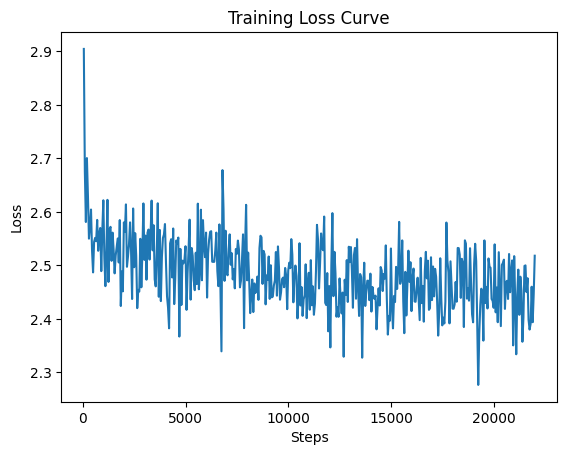

In [24]:
import matplotlib.pyplot as plt

# Filter out logs that don't have the 'loss' key
steps = [log['step'] for log in trainer.state.log_history if 'loss' in log]
losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]

# Plot the loss
plt.plot(steps, losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


In [13]:
# Create a DataLoader for the evaluation set (same as before)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)

# Set the model to evaluation mode and compute losses after fine-tuning
model.eval()
losses = []
for batch in eval_dataloader:
    with torch.no_grad():
        outputs = model(
            input_ids=batch["input_ids"].to(model.device),
            attention_mask=batch["attention_mask"].to(model.device),
            labels=batch["input_ids"].to(model.device)
        )
        loss = outputs.loss
        losses.append(loss.item())
# Compute the average loss after fine-tuning
finetuned_loss = sum(losses) / len(losses)
print("Loss after fine-tuning:", finetuned_loss)

Loss after fine-tuning: 8.058216146712608


In [16]:
# Perplexity is calculated as the exponential of the loss (for language modeling tasks)
baseline_perplexity = math.exp(baseline_loss)
finetuned_perplexity = math.exp(finetuned_loss)
print("Baseline Perplexity:", baseline_perplexity)
print("Fine-tuned Perplexity:", finetuned_perplexity)

Baseline Perplexity: 1480.3659857279526
Fine-tuned Perplexity: 3159.6487543385874


In [17]:
# Here, we provide an example prompt and generate text using the fine-tuned model.
# (In practice, you might want to compare outputs using both the original and fine-tuned models)
prompt = "The history of artificial intelligence is"
# Tokenize the prompt and convert to tensor
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

# Generate text with a maximum length of 100 tokens
generated_ids = model.generate(input_ids, max_length=100)
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Generated text after fine-tuning:")
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated text after fine-tuning:
The history of artificial intelligence is the study of the development of technology that simulates human intelligence. The field is divided into sub @-@ fields, including machine learning, computer vision, natural language processing, and robotics. 
Artificial intelligence is a term that has been used in a variety of contexts, including in the context of human @-@ computer interaction, and has been used to describe the ability of a computer system to perform tasks that are normally associated with human intelligence. 
The term
